# Practical: climate change in the Arctic 

What is inside this notebook? 

- An introduction to some basic (and more advanced) python 
- Examples of how to download climate data from reanalysis, climate models and other sources
- Examples of how to plot maps of a climate variable 
- Some basic data analysis such as averaging, showing anomalies, calculating trends etc
- We will treat one sub-region of the planet (here Turkey) but you can easily adapt the analysis to another region of your choice

This notebook has evolved from a practical I gave in 2019/2020 in my principle of climates class at UCL. For more information on how install the relevant packages on your own computer look at the guidelines here: https://github.com/mimi1981/GEOL0013_Python_Practical

The outline of the notebook is as follows:

1. Import all required libraries
2. Retrieve ERA5 reanalysis data

# Import all required libraries

To get things done more easily we need use code developed and shared by the python community. If you find that some of these libraries do not work for you then you will need to install it on your environment.

Typically use pip install < name of software > or conda install < name of software > and google is your friend for install instruction.

In [23]:
! pip install cartopy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [24]:
! pip instal cftim==1.4.1

ERROR: unknown command "instal" - maybe you meant "install"


In [25]:
from netCDF4 import Dataset as netcdf 
from scipy import signal
# import cdsapi
from pylab import *
import numpy as np
import os
import matplotlib.pyplot as plt
import datetime
import scipy.stats as stats
import cftime
from cftime import utime
import zipfile
import warnings
import pandas as pd
import statsmodels.api as sm
warnings.simplefilter('ignore')
import matplotlib.dates as mdateschan
from matplotlib.dates import MonthLocator, WeekdayLocator, DateFormatter
import matplotlib.ticker as ticker
from matplotlib.pylab import rcParams
import matplotlib.dates as mdates
from matplotlib import pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import zipfile
import xarray as xr



# Looking at historical data 



## Retrieve ERA5 reanalysis data

Reanalysis is a scientific method for developing a comprehensive record of how weather and climate are changing over time. In it, observations and a numerical model that simulates one or more aspects of the Earth system are combined objectively to generate a synthesized estimate of the state of the system.

Here we will <a href="https://climate.copernicus.eu/climate-reanalysisERA5" target="ERA5">ERA5</a> which is the latest climate reanalysis produced by <a href="https://www.ecmwf.int/" target="ECMWF">ECMWF</a>, providing hourly data on many atmospheric, land-surface and sea-state parameters together with estimates of uncertainty.

We chose a timespan of 41 years and a limited regional subsample of the whole planet to be able to run the analysis on the cloud (limits in memory). 

In order to be able to install the climate data you need to follow the procedure outlined here: 
https://cds.climate.copernicus.eu/api-how-to

In [26]:
#Download ERA5 Med data directly from my Google Drive 
! gdown --id 13G9gv0QS9vgG9Theg8gBUzHyZYPhiC_g

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=13G9gv0QS9vgG9Theg8gBUzHyZYPhiC_g
To: /content/download_med.nc
100% 64.1M/64.1M [00:00<00:00, 231MB/s]


In [30]:
# #No need to run this if you have already downloaded the data

# import cdsapi # Let's move this to the cell above?

# c = cdsapi.Client()
 
# c.retrieve(
#     'reanalysis-era5-single-levels-monthly-means',
#     {
#         'area' : [50, 10, 30, 60], # North, West, South, East. Default: global
#         'format': 'netcdf',
#         'product_type': 'monthly_averaged_reanalysis',
#         'variable': [
#             '2m_temperature', 'sea_surface_temperature', 'surface_pressure', 'total_precipitation',
#         ],
#         'year': [
#             '1979', '1980', '1981',
#             '1982', '1983', '1984',
#             '1985', '1986', '1987',
#             '1988', '1989', '1990',
#             '1991', '1992', '1993',
#             '1994', '1995', '1996',
#             '1997', '1998', '1999',
#             '2000', '2001', '2002',
#             '2003', '2004', '2005',
#             '2006', '2007', '2008',
#             '2009', '2010', '2011',
#             '2012', '2013', '2014',
#             '2015', '2016', '2017',
#             '2018', '2019',
#         ],
#         'month': [
#             '01', '02', '03',
#             '04', '05', '06',
#             '07', '08', '09',
#             '10', '11', '12',
        
#         ],
#         'time': '00:00',
        
#     },
#     '../data/download_med.nc')


Now you should see that the data is available in your working directory. 

The exclamation point ! allows you to type commands on the notebook as if you were directly working on your unix terminal.

In [ ]:
! ls 

2020-10-03-074900.term	  Climate_Practical.ipynb
2020-10-04-235253.course  Climate_Practical_Arctic.ipynb


## Plotting air temperature maps

__Reading the data__

To get going we need to read in the data from the netcdf files. We can either do that by loading the data into arrays using the netcdf read command: 

In [ ]:
#Read data
ncset = netcdf('../data/download_med.nc', mode='r')
#To check which variables are in the netcdf files
#ncset.variables
ncset.set_auto_mask(False)

#Read variables
lon = ncset['longitude'][:]
lat = ncset['latitude'][:]
t = ncset['time'][:]
t2m = ncset['t2m'][:]
nctime = ncset.variables['time'][:]
t_unit = ncset.variables['time'].units
# t_unit = t.units
ncset.close()

try:
    t_cal = ncset.variables['time'].calendar
    t_cal = nctime.calendar
except AttributeError:  # Attribute doesn't exist
    t_cal = u"gregorian"  # or standard
utime = cftime.utime(t_unit, calendar=t_cal)
datevar = utime.num2date(nctime)

#lons lats on a grid
[lons, lats] = meshgrid(lon, lat)

#Size of array
t2m.shape

(492, 81, 201)

In [27]:
print(datevar[0])

1979-01-01 00:00:00


Or we can load the data into the more advanced and versatile xarray structure. 

For a 45 minutes intro on what these are read here https://xarray-contrib.github.io/xarray-tutorial/oceanhackweek-2020/xarray-oceanhackweek20.html

In [28]:
#load data
import xarray as xr
ds = xr.open_dataset('./download_med.nc')
print(ds)

<xarray.Dataset>
Dimensions:    (longitude: 201, latitude: 81, time: 492)
Coordinates:
  * longitude  (longitude) float32 10.0 10.25 10.5 10.75 ... 59.5 59.75 60.0
  * latitude   (latitude) float32 50.0 49.75 49.5 49.25 ... 30.5 30.25 30.0
  * time       (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2019-12-01
Data variables:
    t2m        (time, latitude, longitude) float32 ...
    sst        (time, latitude, longitude) float32 ...
    sp         (time, latitude, longitude) float32 ...
    tp         (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2020-10-01 13:48:02 GMT by grib_to_netcdf-2.16.0: /opt/ecmw...


We can then plot the data in the simplest possible way using arrays

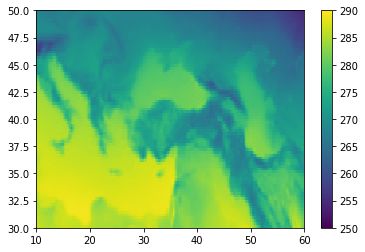

In [29]:
plt.pcolormesh(lons,lats,t2m[0],vmin=250,vmax=290)
plt.colorbar()

For a better look and more options you can show the data on a map using Cartopy.

For a short tutorial on Cartopy have a look here https://earth-env-data-science.github.io/lectures/mapping_cartopy.html


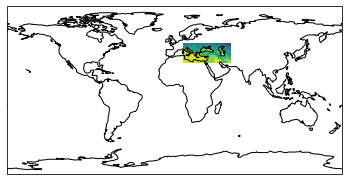

In [31]:
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()
ax.coastlines()
ax.contourf(lons,lats,t2m[0],vmin=250,vmax=290) #no need to specify transform because simplest projection


Show data on a map with Cartopy with a different projection.

For a list of cartopy projections see https://scitools.org.uk/cartopy/docs/latest/crs/projections.html


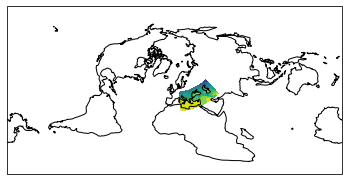

In [32]:
projection = ccrs.RotatedPole(pole_longitude=-177.5, pole_latitude=37.5)
ax = plt.axes(projection=projection)
ax.set_global()
ax.coastlines()
ax.contourf(lons,lats,t2m[0],vmin=250,vmax=290, transform=ccrs.PlateCarree())

For an even better feel you can show the data on map using xarray


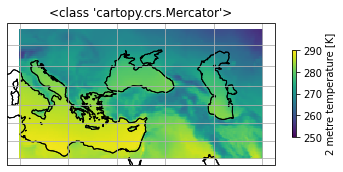

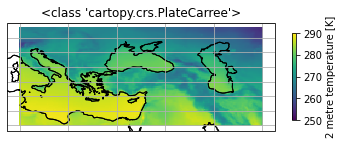

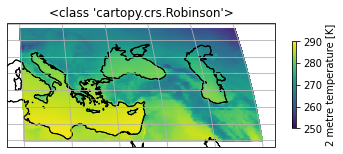

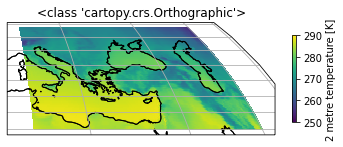

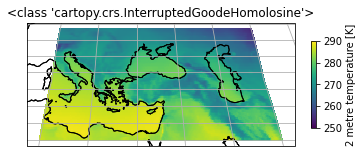

In [33]:
#plot data on other projections

projections = [ccrs.Mercator(),
               ccrs.PlateCarree(),
               ccrs.Robinson(),
               ccrs.Orthographic(),
               ccrs.InterruptedGoodeHomolosine()
              ]

t2m_test = ds.t2m.sel(time='1979-01-01', method='nearest')

for proj in projections:
    plt.figure()
    ax = plt.axes(projection=proj)
#     ax.stock_img()
    ax.coastlines()
    
    
#     fig = plt.figure(figsize=(18,12))
#     ax = plt.axes(projection=ccrs.Orthographic())
    ax.coastlines()
    ax.gridlines()
    t2m_test.plot(ax=ax, transform=ccrs.PlateCarree(),
             vmin=250, vmax=290, cbar_kwargs={'shrink': 0.4})


    ax.set_title(f'{type(proj)}')
    
    


Text(0.5, 1.0, 'difference: 2019-01-01 vs 1979-01-01')

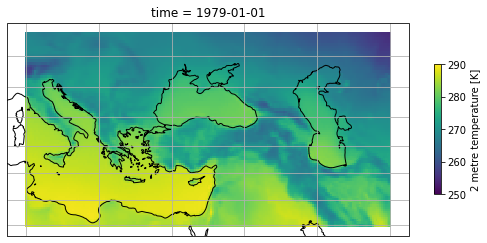

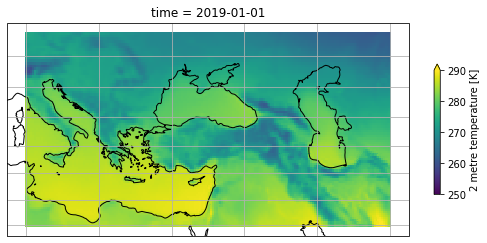

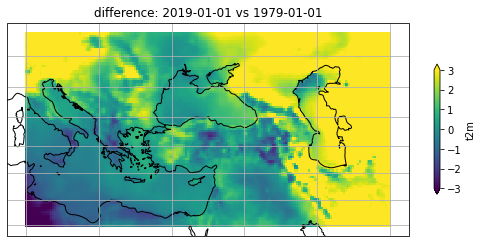

In [34]:
#plot data
date_years=['1979-01-01','2019-01-01']
# date_years=['1979-07-01','1989-07-01','1999-07-01','2009-07-01','2019-07-01']
for year in date_years:
    t2m_test = ds.t2m.sel(time=year, method='nearest')
    fig = plt.figure(figsize=(9,6))
    ax = plt.axes(projection=ccrs.Mercator())
    ax.coastlines()
    ax.gridlines()
    t2m_test.plot(ax=ax, transform=ccrs.PlateCarree(),
             vmin=250, vmax=290, cbar_kwargs={'shrink': 0.4})
    
t2m_test_2 = ds.t2m.sel(time=date_years[1], method='nearest')
t2m_test_1 = ds.t2m.sel(time=date_years[0], method='nearest')
fig = plt.figure(figsize=(9,6))
ax = plt.axes(projection=ccrs.Mercator())
ax.coastlines()
ax.gridlines()
# ax.set_title('difference')
(t2m_test_2-t2m_test_1).plot(ax=ax, transform=ccrs.PlateCarree(),
         vmin=-3, vmax=3, cbar_kwargs={'shrink': 0.4})
plt.title('difference: '+date_years[1]+' vs '+date_years[0])



Questions: 

- What are we showing on this last map? Explain 
- Are these significant? 
- How can you explain the regional patterns? 
- How can you make your results more robust? 

To help us answer these questions we need to delve deeper into the data...

__Some basic statistical analysis__

What if we looked at a different month

https://github.com/Yefee/xMCA

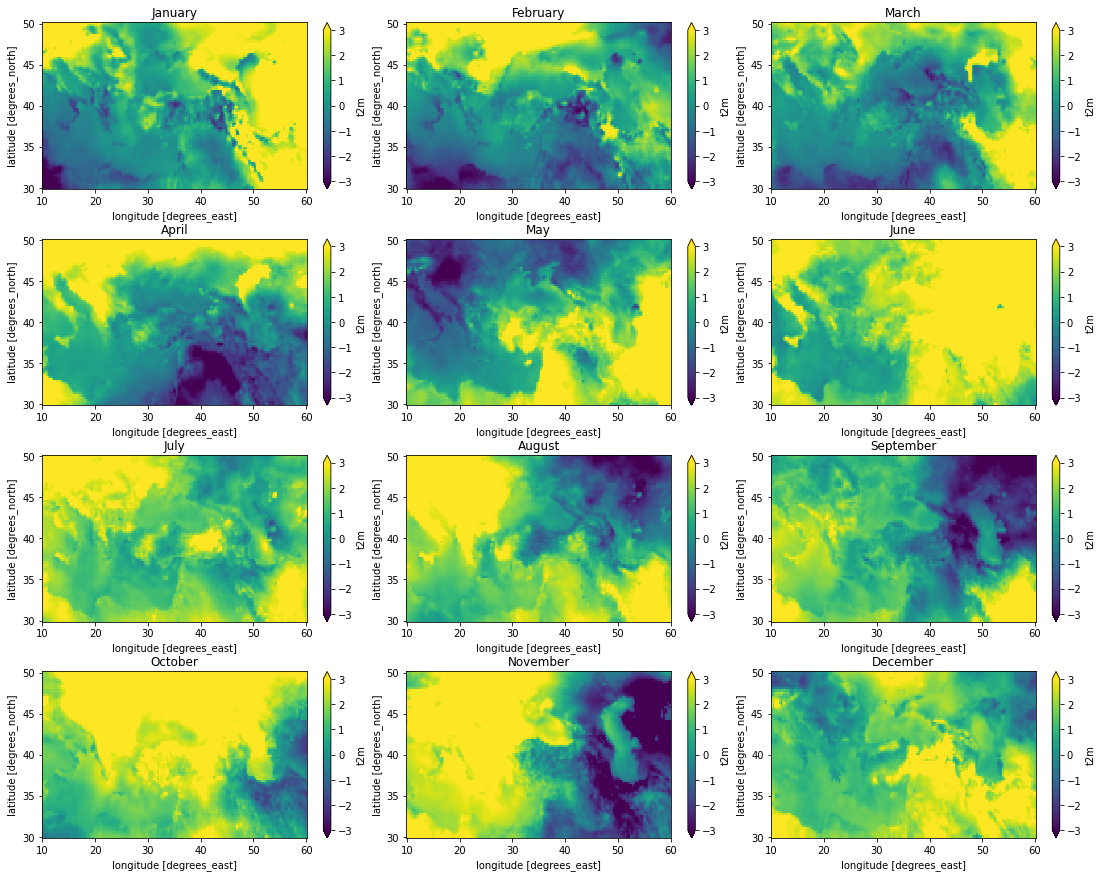

In [35]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 3, figsize=(19, 15))
fig.subplots_adjust(hspace=0.3, wspace=0.1)
list_months=['January','February','March','April','May','June','July','August','September','October','November','December']
for i in range(3):
    ax=ax1[i]
    (ds.t2m.isel(time=i+40*12)-ds.t2m.isel(time=i)).plot(ax=ax,vmin=-3,vmax=3,extend='both')
    ax.set_title(list_months[i])

for i in range(3):
    ax=ax2[i]
    (ds.t2m.isel(time=i+3+40*12)-ds.t2m.isel(time=i+3)).plot(ax=ax2[i],vmin=-3,vmax=3,extend='both')
    ax.set_title(list_months[i+3])

for i in range(3):
    ax=ax3[i]
    (ds.t2m.isel(time=i+6+40*12)-ds.t2m.isel(time=i+6)).plot(ax=ax,vmin=-3,vmax=3,extend='both')
    ax.set_title(list_months[i+6])


for i in range(3):
    ax=ax4[i]
    (ds.t2m.isel(time=i+9+40*12)-ds.t2m.isel(time=i+9)).plot(ax=ax4[i],vmin=-3,vmax=3,extend='both')
    ax.set_title(list_months[i+9])
# Let's do titles for these

So it seems like not all months are getting warmer and not all regions are equal in terms of global warming!

What about the same difference when average over an entire year?

In [36]:
ds_y = ds.groupby('time.year').mean(dim='time')
print(ds_y)

<xarray.Dataset>
Dimensions:    (longitude: 201, latitude: 81, year: 41)
Coordinates:
  * longitude  (longitude) float32 10.0 10.25 10.5 10.75 ... 59.5 59.75 60.0
  * latitude   (latitude) float32 50.0 49.75 49.5 49.25 ... 30.5 30.25 30.0
  * year       (year) int64 1979 1980 1981 1982 1983 ... 2016 2017 2018 2019
Data variables:
    t2m        (year, latitude, longitude) float32 281.3 281.3 ... 296.8 293.8
    sst        (year, latitude, longitude) float32 nan nan nan ... nan nan nan
    sp         (year, latitude, longitude) float32 9.774e+04 ... 8.614e+04
    tp         (year, latitude, longitude) float32 0.002079 ... 0.0004897


Text(0.5, 1.0, 'difference: 2019 vs 1979')

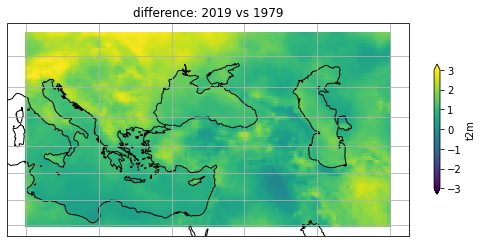

In [37]:
fig = plt.figure(figsize=(9,6))
ax = plt.axes(projection=ccrs.Mercator())
ax.coastlines()
ax.gridlines()
(ds_y.t2m.sel(year=2019)-ds_y.t2m.sel(year=1979)).plot(ax=ax, transform=ccrs.PlateCarree(), vmin=-3,vmax=3,extend='both', cbar_kwargs={'shrink': 0.4})
plt.title('difference: 2019 vs 1979')

Compare these temperature differences with the average 1979-2019 value and the standard deviation.

Using standard arrays:

In [38]:
#Mean
t2m_avg = np.mean(t2m, axis=0) 
# calculate mean for all years and months
t2m_avg.shape
 
#Standard deviation 
t2m_std=np.std(t2m, axis=0)
t2m_std.shape

#Visualising mean and standard deviation on global scale
minu = floor(np.min(t2m_avg))
maxu = ceil(np.max(t2m_avg))

Text(0.5, 1.0, 'Temperature standard deviation 2019-1979')

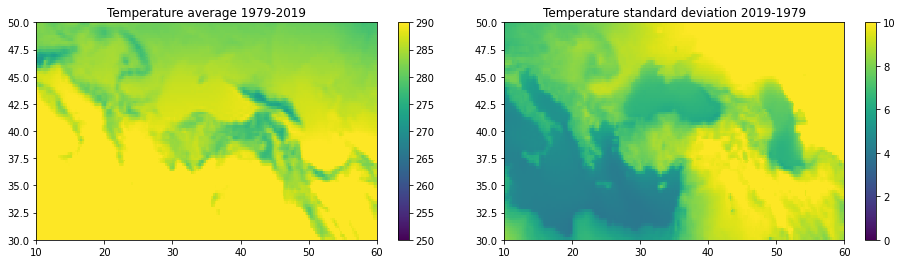

In [39]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
fig.subplots_adjust(hspace=0.1, wspace=0.1)


im1=ax1.pcolormesh(lons,lats,t2m_avg,vmin=250,vmax=290)
fig.colorbar(im1,ax=ax1)
ax1.set_title('Temperature average 1979-2019')

im2=ax2.pcolormesh(lons,lats,t2m_std,vmin=0,vmax=10)
fig.colorbar(im2,ax=ax2)
ax2.set_title('Temperature standard deviation 2019-1979')


Using xarray functionalities:

Text(0.5, 1.0, 'Temperature standard deviation 1979-2019')

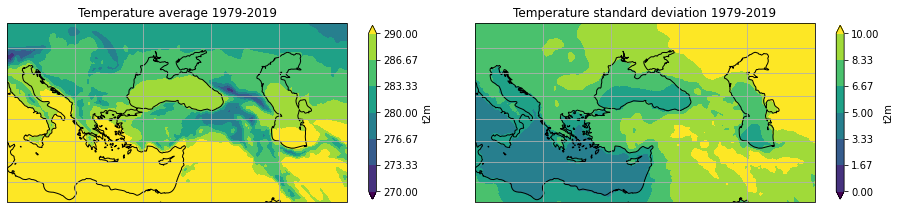

In [40]:
#  Plotting

ds_avg = ds.t2m.mean(dim='time')
# print(ds_avg)


fig = plt.figure(figsize=(16, 4))
fig.subplots_adjust(hspace=0.1, wspace=0.1)

ax1 = fig.add_subplot(121, projection = ccrs.Mercator())
ds.t2m.mean(dim='time').plot.contourf(ax = ax1, transform = ccrs.PlateCarree(), vmin = 270, vmax = 290, extend='both', cbar_kwargs = {'shrink': 0.8})
ax1.add_feature(cfeature.COASTLINE)
ax1.gridlines()
ax1.set_title('Temperature average 1979-2019')

ax2 = fig.add_subplot(122, projection = ccrs.Mercator())
# ds.t2m.std(dim='time').plot(ax = ax2, transform = ccrs.PlateCarree(),  vmin = 0, vmax = 10, extend = 'both', cbar_kwargs = {'shrink': 0.8})
ds.t2m.std(dim='time').plot.contourf(ax = ax2, transform = ccrs.PlateCarree(),vmin = 0, vmax = 10, extend = 'both', cbar_kwargs = {'shrink': 0.8})
ax2.add_feature(cfeature.COASTLINE)
ax2.gridlines()
ax2.set_title('Temperature standard deviation 1979-2019')


So are these temperature changes over the last 40 years significant? To answer this question quantitatively we need some more statistical tools...

## Calculating and plotting temperature trends (and significance)

Calculate rates on each grid cell

See other similar approach here https://nbviewer.jupyter.org/github/certik/climate/blob/master/RSS%20plots.ipynb

In [41]:
###############################################################################################
# Function to calculate the spatial mean of one field and write the trends in .dat files
# returns
#          ---> trend_time[year]
#          ---> trend_space[x,y]
#
# Similar code by Alek Petty
##############################################################################################

def cal_trend(start_year, num_years, start_month, num_months, nx, ny, var):

# Initialize
        x = nx
        y = ny

##################
# Maps of trends
##################

# Monthly averaged
        num_years
        years = np.arange(num_years)
        trend_ym = np.zeros((num_months, x, y))
        sig_a_ym = np.zeros((num_months, x, y))
        r_a_ym = np.zeros((num_months, x, y))
        int_a_ym = np.zeros((num_months, x, y))

        for month in range(num_months):
                print (month)
                var_y = np.mean(var,1)
                for i in range(x):
                        for j in range(y):
                                slope, intercept, r, prob, stderr = stats.linregress(years,var[start_year:start_year+num_years, month, i, j])
                                trend_ym[month, i, j] = slope
                                sig_a_ym[month, i, j] = 100*(1-prob)
                                r_a_ym[month, i, j] = r
                                int_a_ym[month, i, j] = intercept

# Yearly averaged
        years = np.arange(num_years)
        trend = np.zeros((x, y))
        sig_a = np.zeros((x, y))
        r_a = np.zeros((x, y))
        int_a = np.zeros((x, y))

        for i in range(x):
                for j in range(y):
                        slope, intercept, r, prob, stderr = stats.linregress(years,var_y[start_year:start_year+num_years, i, j])
                        trend[i, j] = slope
                        sig_a[i, j] = 100*(1-prob)
                        r_a[i, j] = r
                        int_a[i, j] = intercept

        return trend, trend_ym, sig_a, sig_a_ym, r_a, r_a_ym, int_a, int_a_ym

Putting the data in the right format for the cal_trend function

In [42]:

t2m_ym=t2m.reshape(41,12,81,201)
# print(t2m_ym[1,1,0,0],t2m[13,0,0])


start_year=1979-1979
num_years=41
start_month=0
num_months=12
nx=t2m_ym.shape[2]
ny=t2m_ym.shape[3]
t2m_trend, t2m_trend_ym, t2m_sig_a, t2m_sig_a_ym, t2m_r_a, t2m_r_a_ym, t2m_int_a, int_a_ym = cal_trend(start_year, num_years, start_month, num_months, nx, ny, t2m_ym)


0
1
2
3
4
5
6
7
8
9
10
11


Faster way to calculate interpolation but does not provide significance (i.e. p-value)

In [43]:
nt, nlat, nlon = t2m.shape
ngrd = nlon*nlat


#Linear trend calculation
t2m_grd  = t2m.reshape((nt, ngrd), order='F') 
x        = np.linspace(1,nt,nt) #.reshape((nt,1))
t2m_rate = np.empty((ngrd,1))
t2m_rate[:,:] = np.nan

for i in range(ngrd): 
    y = t2m_grd[:,i]   
    if(not np.ma.is_masked(y)):         
        z = np.polyfit(x, y, 1)
        t2m_rate[i,0] = z[0]*120.0

t2m_rate = t2m_rate.reshape((nlat,nlon), order='F')

Plot the trends directly from the newly created numpy.array

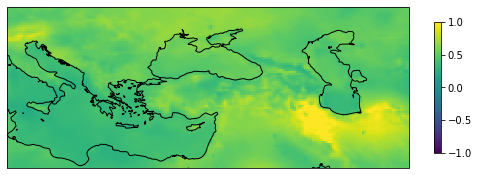

In [44]:
fig = plt.figure(figsize=(9,6))
ax = plt.axes(projection=ccrs.PlateCarree())
# ax = plt.axes(projection=ccrs.Mercator())
ax.set_global()
ax.coastlines()
plt.pcolormesh(lons,lats,t2m_rate,vmin=-1,vmax=1)
# plt.contourf(lons,lats,t2m_rate, extend='both',vmin=-1,vmax=1)
lat1, lon1, lat2, lon2 = 30, 10, 50, 60
ax.set_extent([lon1, lon2, lat1, lat2], crs=ccrs.PlateCarree())
plt.colorbar(ax=ax,shrink=0.4)


Or we can create an xarray with the new calculated trends and plot with xarray functionalities

See for example http://xarray.pydata.org/en/stable/data-structures.html


Text(0.5, 1.0, 'Temperature trend (K/decade) for 1979-2019 ')

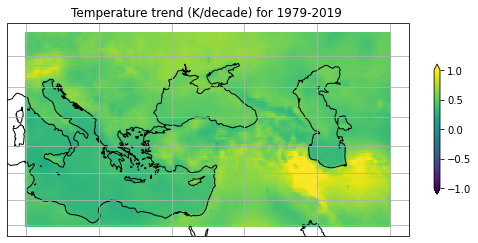

In [45]:
#calculated with polyfit
data=t2m_rate
ds_trend1 = xr.DataArray(data, coords=[ds.latitude,ds.longitude], dims=["longitude","latitude"])
fig = plt.figure(figsize=(9,6))
ax = plt.axes(projection=ccrs.Mercator())
ax.coastlines()
ax.gridlines()
(ds_trend1).plot(ax=ax, transform=ccrs.PlateCarree(), vmin=-1,vmax=1,extend='both', cbar_kwargs={'shrink': 0.4})
# (ds_trend).plot.contourf(ax=ax, transform=ccrs.PlateCarree(), vmin=-1,vmax=1,extend='both', cbar_kwargs={'shrink': 0.4})
plt.title('Temperature trend (K/decade) for 1979-2019 ')

Text(0.5, 1.0, 'Temperature trend (K/decade) for 1979-2019 ')

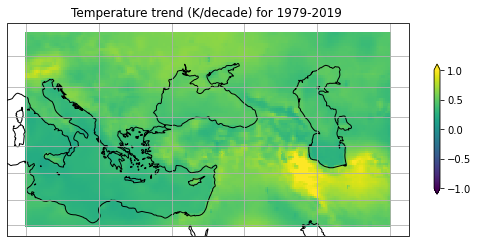

In [46]:
#Calculated with linregress
data=t2m_trend
ds_trend = xr.DataArray(data, coords=[ds.latitude,ds.longitude], dims=["longitude","latitude"])
fig = plt.figure(figsize=(9,6))
ax = plt.axes(projection=ccrs.Mercator())
ax.coastlines()
ax.gridlines()
(10.*ds_trend).plot(ax=ax, transform=ccrs.PlateCarree(), vmin=-1,vmax=1,extend='both', cbar_kwargs={'shrink': 0.4})
# (ds_trend).plot.contourf(ax=ax, transform=ccrs.PlateCarree(), vmin=-1,vmax=1,extend='both', cbar_kwargs={'shrink': 0.4})
plt.title('Temperature trend (K/decade) for 1979-2019 ')

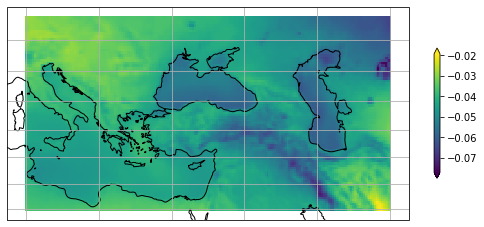

In [47]:
#Massive difference in the results?! Check which is correct
fig = plt.figure(figsize=(9,6))
ax = plt.axes(projection=ccrs.Mercator())
ax.coastlines()
ax.gridlines()
(10.*ds_trend-ds_trend1).plot(ax=ax, transform=ccrs.PlateCarree(),extend='both', cbar_kwargs={'shrink': 0.4})

Now make a good looking plot with showing significant trends and masking irrelevant regions 

Inspired by figure2 of https://www.nature.com/articles/s41558-020-0825-x/figures/2?proof=t

With code shared here https://github.com/AndreasPrein/Increasing-Melting-Level-Height/blob/master/plots/Seasonal_Trends/Seasonal_Trends.py

For yearly trends

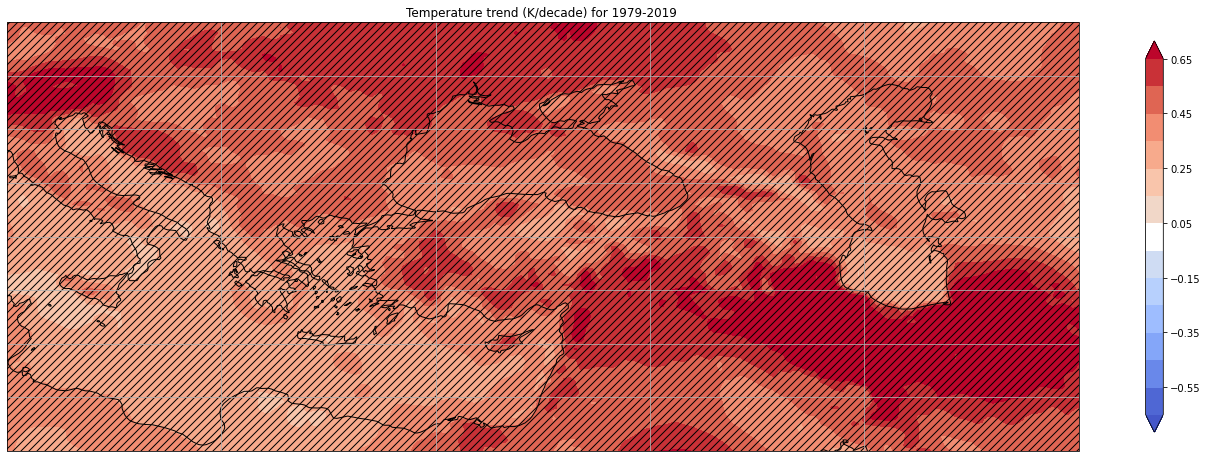

In [48]:
#Create color scheme and colorbar
biasContDist=0.1
rgrColorTable=np.array(['#4457c9','#4f67d4','#6988ea','#84a6f9','#9ebdff','#b7d0fd','#cfdcf3','#ffffff','#f1d7c8','#f9c5ab','#f7aa8c','#f28d72','#df6553','#c93137','#bc052b'])
iContNr=len(rgrColorTable)
iMinMax=12.*biasContDist/2.+biasContDist/2.
clevsTD=np.arange(-iMinMax,iMinMax+0.0001,biasContDist)

data=t2m_trend
ds_trend = xr.DataArray(data, coords=[ds.latitude,ds.longitude], dims=["longitude","latitude"])
fig = plt.figure(figsize=(24,18))
# ax = plt.axes(projection=ccrs.Mercator())
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines()
# (ds_trend).plot.contourf(ax=ax, colors=rgrColorTable, levels=clevsTD, zorder=0, extend='both', cbar_kwargs={'shrink': 0.4})
cs=plt.contourf(lons,lats,t2m_sig_a, hatches=['','///'],levels=[0,90,100], zorder=1, alpha=0)# ,transform=cartopy.crs.PlateCarree())
plt.contourf(lons,lats,10.*ds_trend,colors=rgrColorTable, extend='both',levels=clevsTD, zorder=0)

plt.title('Temperature trend (K/decade) for 1979-2019 ')
# ax.set_extent(crs=ccrs.PlateCarree())
plt.colorbar(ax=ax,shrink=0.4)



And for individual months

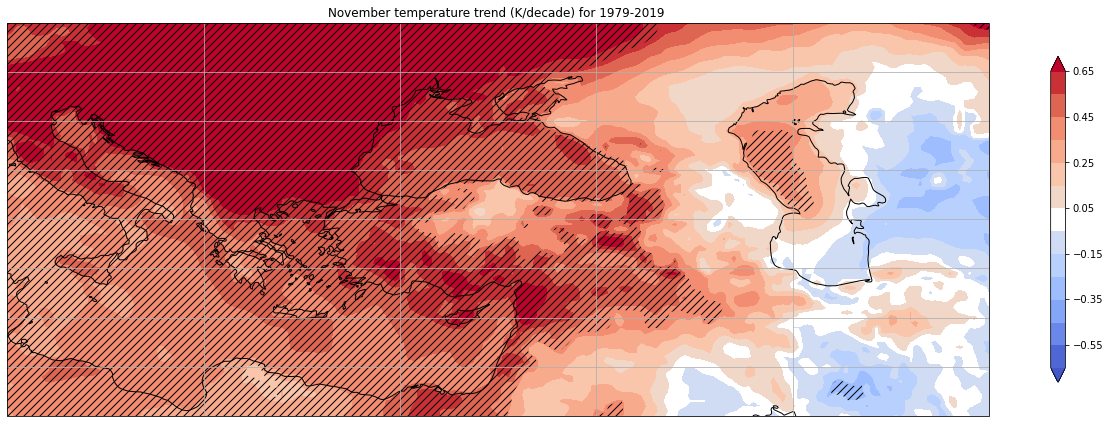

In [49]:
list_months=['January','February','March','April','May','June','July','August','September','October','November','December']
month=10 #8 = September
data=t2m_trend_ym[month]
ds_trend = xr.DataArray(data, coords=[ds.latitude,ds.longitude], dims=["longitude","latitude"])
fig = plt.figure(figsize=(22,15))
# ax = plt.axes(projection=ccrs.Mercator())
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines()
# cs=plt.contourf(lons,lats,t2m_sig_a_ym[month], hatches=['xxx',''],levels=[0,90,100], zorder=1, alpha=0)# ,transform=cartopy.crs.PlateCarree()) #hatches not significant
cs=plt.contourf(lons,lats,t2m_sig_a_ym[month], hatches=['','///'],levels=[0,90,100], zorder=1, alpha=0)# ,transform=cartopy.crs.PlateCarree()) #hatches significant
plt.contourf(lons,lats,10.*ds_trend,colors=rgrColorTable, extend='both',levels=clevsTD, zorder=0)
# (ds_trend).plot.contourf(ax=ax, colors=rgrColorTable, levels=clevsTD, zorder=0, extend='both', cbar_kwargs={'shrink': 0.4})
plt.title(list_months[month]+' temperature trend (K/decade) for 1979-2019 ')
# ax.set_extent(crs=ccrs.PlateCarree())
plt.colorbar(ax=ax,shrink=0.4)


If you want to select only data from a subset of your full array. For example if you want to only analyse a smaller region of interest or to save on computation time. 

Turkey 
Lat: 30 ~ 50
Lon: 10 ~ 60

__Get indices of time, lat and lon over your area__

In [50]:
idx_lat_region  = (lat>=35.0) * (lat<=45.0)
idx_lon_region  = (lon>=20.0) * (lon<=55.0)
# time: 1970-1999

years = np.array([idx.year for idx in datevar])
idx_tim_region = (years>=1979) * (years<=2019)
# Get Index using np.nonzero

idxtim = nonzero(idx_tim_region)[0]
#idxlat = nonzero(idx_lat_region)[0]
idxlon = nonzero(idx_lon_region)[0]
idxlon

array([ 40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180])

Mask the original arrays (t2m) and create a new smaller array (t2m_region)

In [51]:
lat_region = lat[idx_lat_region]
lon_region = lon[idx_lon_region]
dates_region  = datevar[idx_tim_region]

t2m_region = t2m[idx_tim_region, :, :][:,idx_lat_region,:][:,:,idx_lon_region]
print(t2m_region.shape)
print(dates_region.shape)

(492, 41, 141)
(492,)


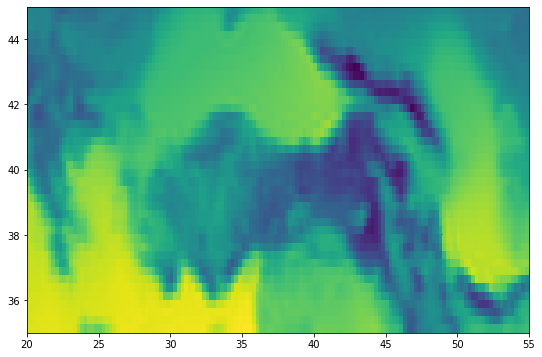

In [53]:
fig = plt.figure(figsize=(9,6))
[lons_region, lats_region] = meshgrid(lon_region,lat_region)
plt.pcolormesh(lons_region,lats_region,t2m_region[480])

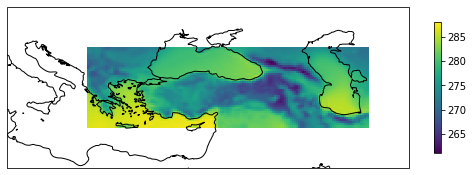

In [54]:
# fig = plt.figure(figsize=(9,6))
# [lons_region, lats_region] = meshgrid(lon_region,lat_region)
# plt.pcolormesh(lons_region,lats_region,t2m_region[480])


fig = plt.figure(figsize=(9,6))
ax = plt.axes(projection=ccrs.PlateCarree())
# ax = plt.axes(projection=ccrs.Mercator())
ax.set_global()
ax.coastlines()
plt.pcolormesh(lons_region,lats_region,t2m_region[480])#,vmin=-1,vmax=1)
# plt.contourf(lons,lats,t2m_rate, extend='both',vmin=-1,vmax=1)
lat1, lon1, lat2, lon2 = 30, 10, 50, 60
ax.set_extent([lon1, lon2, lat1, lat2], crs=ccrs.PlateCarree())
plt.colorbar(ax=ax,shrink=0.4)


## Time series analysis 

First lets look at the data in one chosen location defined by its latitude and longitude. 

A lot of useful examples are available here https://rabernat.github.io/research_computing_2018/intermediate-xarray.html and here http://xarray.pydata.org/en/stable/examples/weather-data.html

Lets look at the temperature record for Istanbul (lat=41.015137, lon=28.979530.)

In [55]:
#https://github.com/geopy/geopy
#https://developers.google.com/maps/documentation/geocoding/overview
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="Google Geocoding API (V3)")
location = geolocator.geocode("Istanbul")
print(location.address)
print(geolocator.geocode("Istanbul").longitude,geolocator.geocode("Istanbul").latitude)

İstanbul, Fatih, İstanbul, Marmara Bölgesi, 34126, Türkiye
28.9662187 41.0091982


In [ ]:
# print(ds.t2m)

Text(0.5, 1.0, 'Compare ERA5 temperature record for Istanbul, Athens, and Ankara')

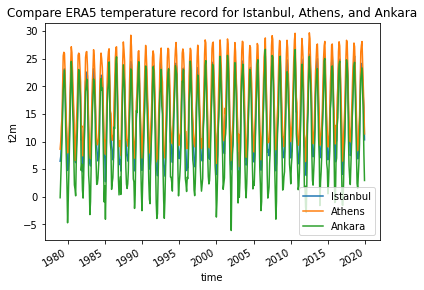

In [56]:

# Get coords of cities
lon1,lat1=geolocator.geocode("Istanbul").longitude,geolocator.geocode("Istanbul").latitude
lon2,lat2=geolocator.geocode("Athens").longitude,geolocator.geocode("Athens").latitude
lon3,lat3=geolocator.geocode("Ankara").longitude,geolocator.geocode("Ankara").latitude

# Get data for coords
(ds.t2m.sel(longitude=lon1, latitude=lat1, method = 'nearest')-273.15).plot(x="time")
(ds.t2m.sel(longitude=lon2, latitude=lat2, method = 'nearest')-273.15).plot(x="time")
(ds.t2m.sel(longitude=lon3, latitude=lat3, method = 'nearest')-273.15).plot(x="time")

# labels = range(3)
labels = ['Istanbul','Athens','Ankara']
# plt.figure(figsize=(18,5))
plt.legend(labels,loc='lower right')
plt.title('Compare ERA5 temperature record for ' + labels[0] +', '+ labels[1]+ ', and ' +labels[2])
# ds.t2m.sel(longitude=geolocator.geocode("Athens").longitude, latitude=geolocator.geocode("Athens").latitude,method = 'nearest').plot(x="time")
# print(ds.t2m['longitude'])

One can remove the seasonal (monthly) cycle to only focus on temoperature anomalies

Text(0.5, 1.0, 'Compare ERA5 temperature anomaly record for Istanbul, Athens, and Ankara')

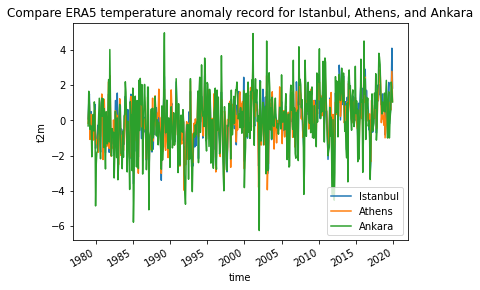

In [57]:
def remove_time_mean(x):
    return x - x.mean(dim='time')

monthly_annual_anom = ds.t2m.groupby('time.month').apply(remove_time_mean)
monthly_annual_anom.sel(longitude=lon1, latitude=lat1, method = 'nearest').plot.line(x="time")
monthly_annual_anom.sel(longitude=lon2, latitude=lat2, method = 'nearest').plot.line(x="time")
monthly_annual_anom.sel(longitude=lon3, latitude=lat3, method = 'nearest').plot.line(x="time")
labels = ['Istanbul','Athens','Ankara']
plt.legend(labels,loc='lower right')
plt.title('Compare ERA5 temperature anomaly record for ' + labels[0] +', '+ labels[1]+ ', and ' +labels[2])

In [58]:
# Timeseries for yearly averages 

Text(0.5, 1.0, 'Compare yearly trends')

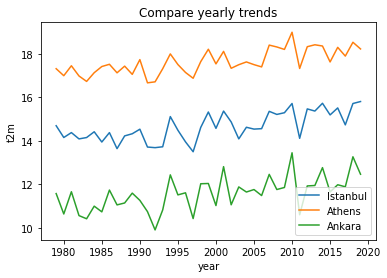

In [59]:


year_annual = (ds['t2m']-273.15).groupby('time.year').mean(dim='time')
year_annual.sel(longitude=lon1, latitude=lat1, method = 'nearest').plot.line(x="year")
year_annual.sel(longitude=lon2, latitude=lat2, method = 'nearest').plot.line(x="year")
year_annual.sel(longitude=lon3, latitude=lat3, method = 'nearest').plot.line(x="year")
labels = ['Istanbul','Athens','Ankara']
plt.legend(labels,loc='lower right')
plt.title('Compare yearly trends')

Timeseries for selected months and locations

Text(0.5, 1.0, 'Compare trends')

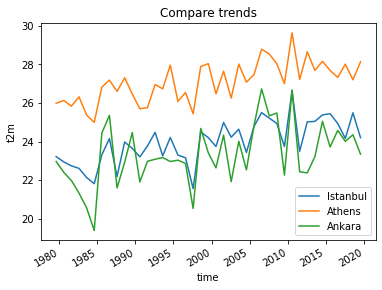

In [60]:

month=8 #9:September
(ds.t2m.sel(longitude=lon1, latitude=lat1,time=ds['time.month']==month, method = 'nearest')-273.15).plot.line(x="time")
(ds.t2m.sel(longitude=lon2, latitude=lat2,time=ds['time.month']==month, method = 'nearest')-273.15).plot.line(x="time")
(ds.t2m.sel(longitude=lon3, latitude=lat3,time=ds['time.month']==month, method = 'nearest')-273.15).plot.line(x="time")
labels = ['Istanbul','Athens','Ankara']
plt.legend(labels,loc='lower right')
plt.title('Compare trends')

Time series for a given season. Adapted from http://atedstone.github.io/rate-of-change-maps/

Text(0.5, 1.0, 'Compare seasonal trends (JJA)')

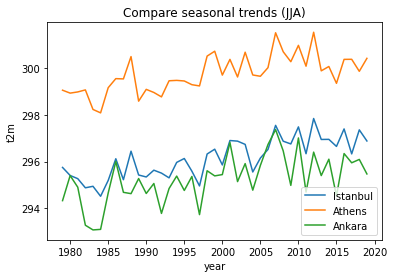

In [61]:
season_str='JJA' #('DJF','MAM','JJA','SON')
season_annual = ds['t2m'].where(ds['t2m']['time.season'] == season_str).groupby('time.year').mean(dim='time')
season_annual.sel(longitude=lon1, latitude=lat1, method = 'nearest').plot.line(x="year")
season_annual.sel(longitude=lon2, latitude=lat2, method = 'nearest').plot.line(x="year")
season_annual.sel(longitude=lon3, latitude=lat3, method = 'nearest').plot.line(x="year")
labels = ['Istanbul','Athens','Ankara']
plt.legend(labels,loc='lower right')
plt.title('Compare seasonal trends ('+ season_str+')')

In [ ]:
print(ds.time[0])

# Looking at 21st century climate projections

RCP2.6 shows the scenario in which greenhouse gas (GHG) concentration levels fall drastically from around 3.1Wm-2 to 2.6Wm-2 by 2099. This represents an idealised case of extreme GHG reduction.

RCP8.5, on the other hand, represents a "business as usual" scenario, where GHGs increase to 8.5Wm-2 by 2100. We chose to look at these two models as they present two extreme cases, and wanted to find out how such extreme scenarios can impact the monsoon cycle in the South and East Asia region.

## RCP 2.6

In [ ]:
# #No need to run this as I have already downloaded the data for you 

# import cdsapi
# #https://cds.climate.copernicus.eu/cdsapp#!/dataset/projections-cmip5-daily-single-levels?tab=form

# c = cdsapi.Client()

# c.retrieve(
#     'projections-cmip5-monthly-single-levels',
#     {
# #         'area' : [50, 10, 30, 60], # North, West, South, East. Default: global
#         'ensemble_member': 'r1i1p1',
#         'format': 'zip',
#         'experiment': 'rcp_2_6',
#         'variable': [
#             '2m_temperature',
#         ],
#         'period': '200601-209912',
#         'model': 'bcc_csm1_1',
#     },
#     '../data/download_26.zip')


2020-10-04 18:12:04,504 INFO Welcome to the CDS


2020-10-04 18:12:04,505 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/projections-cmip5-monthly-single-levels


2020-10-04 18:12:04,721 INFO Request is queued


2020-10-04 18:12:05,816 INFO Request is running


2020-10-04 18:12:18,384 INFO Request is completed


2020-10-04 18:12:18,385 INFO Downloading http://136.156.132.235/cache-compute-0006/cache/data0/dataset-projections-cmip5-monthly-single-levels-b1a72175-12a2-4582-ba97-08cf8bb51495.zip to ../data/download_26.zip (28M)


  0%|          | 0.00/28.0M [00:00<?, ?B/s]

  0%|          | 39.0k/28.0M [00:00<01:56, 251kB/s]

  1%|          | 174k/28.0M [00:00<01:32, 315kB/s] 

  2%|▏         | 480k/28.0M [00:00<01:08, 419kB/s]

  5%|▌         | 1.45M/28.0M [00:00<00:47, 581kB/s]

 11%|█         | 3.10M/28.0M [00:00<00:32, 809kB/s]

 21%|██        | 5.84M/28.0M [00:01<00:20, 1.13MB/s]

 31%|███▏      | 8.80M/28.0M [00:01<00:12, 1.59MB/s]

 37%|███▋      | 10.4M/28.0M [00:01<00:08, 2.18MB/s]

 44%|████▍     | 12.3M/28.0M [00:01<00:05, 2.92MB/s]

 49%|████▉     | 13.8M/28.0M [00:01<00:04, 3.58MB/s]

 56%|█████▌    | 15.6M/28.0M [00:01<00:02, 4.52MB/s]

 60%|█████▉    | 16.7M/28.0M [00:01<00:02, 5.00MB/s]

 63%|██████▎   | 17.8M/28.0M [00:02<00:02, 5.27MB/s]

 67%|██████▋   | 18.7M/28.0M [00:02<00:01, 5.38MB/s]

 71%|███████   | 19.8M/28.0M [00:02<00:01, 5.79MB/s]

 74%|███████▎  | 20.6M/28.0M [00:02<00:01, 6.24MB/s]

 77%|███████▋  | 21.5M/28.0M [00:02<00:01, 6.17MB/s]

 79%|███████▉  | 22.2M/28.0M [00:02<00:00, 6.43MB/s]

 83%|████████▎ | 23.2M/28.0M [00:02<00:00, 6.48MB/s]

 85%|████████▌ | 23.9M/28.0M [00:03<00:00, 6.61MB/s]

 89%|████████▉ | 24.9M/28.0M [00:03<00:00, 6.68MB/s]

 92%|█████████▏| 25.6M/28.0M [00:03<00:00, 6.75MB/s]

 95%|█████████▌| 26.7M/28.0M [00:03<00:00, 6.83MB/s]

 98%|█████████▊| 27.4M/28.0M [00:03<00:00, 6.85MB/s]

2020-10-04 18:12:22,319 INFO Download rate 7.1M/s


Result(content_length=29325553,content_type=application/zip,location=http://136.156.132.235/cache-compute-0006/cache/data0/dataset-projections-cmip5-monthly-single-levels-b1a72175-12a2-4582-ba97-08cf8bb51495.zip)

And from a different model

In [ ]:
# import cdsapi

# c = cdsapi.Client()

# c.retrieve(
#     'projections-cmip5-daily-single-levels',
#     {
#         'ensemble_member': 'r1i1p1',
#         'format': 'zip',
#         'experiment': 'rcp_2_6',
#         'variable': '2m_temperature',
#         'model': 'cesm1_cam5',
#         'period': [
#             '20060101-20401231', '20410101-20751231', '20760101-21001231',
#         ],
#     },
#     '../data/download_26_cesm.zip')

In [ ]:
#No need for this here either 

# #Unzip .zip file 
# # with zipfile.ZipFile('download2.zip','r') as zip_ref:
# with zipfile.ZipFile('../data/download_26.zip','r') as zip_ref:
#     zip_ref.extractall('../data/')
    
# #Add to path
# import os
# from pathlib import Path

# p = Path(os.getcwd())
# p.joinpath('./')

In [62]:
#Download cmip5 data directly from my Google Drive 

! gdown --id 13S0G_Bdh0RZIZxyLcRIWpe78_rpkWQVH #2.6
! gdown --id 13SVox0OJd2486t1Vhae1l7BXDbDvy4C8 #8.5


/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=13S0G_Bdh0RZIZxyLcRIWpe78_rpkWQVH
To: /content/tas_Amon_bcc-csm1-1_rcp26_r1i1p1_200601-209912.nc
100% 37.0M/37.0M [00:00<00:00, 45.3MB/s]
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=13SVox0OJd2486t1Vhae1l7BXDbDvy4C8
To: /content/tas_Amon_bcc-csm1-1_rcp85_r1i1p1_200601-209912.nc
100% 37.0M/37.0M [00:00<00:00, 45.4MB/s]


In [63]:
! ls 

download_med.nc  tas_Amon_bcc-csm1-1_rcp26_r1i1p1_200601-209912.nc
sample_data	 tas_Amon_bcc-csm1-1_rcp85_r1i1p1_200601-209912.nc


In [64]:
#Read data 
mod = netcdf(r'./tas_Amon_bcc-csm1-1_rcp26_r1i1p1_200601-209912.nc')
# mod = netcdf(r'./../data/tas_Amon_bcc-csm1-1_rcp26_r1i1p1_200601-209912.nc')
mod.set_auto_mask(False)
 
#Read variables
lon = mod['lon'][:]  
lat = mod['lat'][:] 
t = mod['time'][:]    
tasmod = mod['tas'][0:1128,:] #Choosing 2m temperature as variable to analyse
 
#Global Mean
tasmod_10y = np.mean(tasmod, axis=0) # calculate mean for all years and months
tasmod_10y.shape

#Standard deviation 
tasmod_10y_std=np.std(tasmod, axis=0)
tasmod_10y_std.shape

#Visualising mean and standard deviation on global scale
minu = floor(np.min(tasmod_10y))
maxu = ceil(np.max(tasmod_10y))

[lons, lats] = meshgrid(lon,lat)
 
# plt.figure(1)
# #m = Basemap(llcrnrlon=60.,llcrnrlat=0.,urcrnrlon=140.,urcrnrlat=57.)
# m = Basemap(llcrnrlon=lonminTurkey,llcrnrlat=latminTurkey,urcrnrlon=lonmaxTurkey,urcrnrlat=latmaxTurkey) 

# m.drawcoastlines()
# m.drawmapboundary(fill_color='aqua')
# h = m.pcolormesh(lons, lats, tasmod_10y, shading='flat',latlon=True, cmap='jet', vmin=198, vmax=308)
# m.colorbar(h, location='bottom', pad="15%", label='[$K$]')
# plt.title('Figure 11: RCP2.6 2m Temperature (2006-2099) over Turkey [$K$]', fontsize = 16)

In [65]:
print(lons.shape)
tasmod.shape

(64, 128)


(1128, 64, 128)

In [67]:
#load data
import xarray as xr
ds_rcp26 = xr.open_dataset('./tas_Amon_bcc-csm1-1_rcp26_r1i1p1_200601-209912.nc')
print(ds_rcp26)

<xarray.Dataset>
Dimensions:    (time: 1128, bnds: 2, lat: 64, lon: 128)
Coordinates:
  * time       (time) object 2006-01-16 12:00:00 ... 2099-12-16 12:00:00
  * lat        (lat) float64 -87.86 -85.1 -82.31 -79.53 ... 82.31 85.1 87.86
  * lon        (lon) float64 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2
    height     float64 ...
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) object ...
    lat_bnds   (lat, bnds) float64 ...
    lon_bnds   (lon, bnds) float64 ...
    tas        (time, lat, lon) float32 ...
Attributes: (12/30)
    institution:            Beijing Climate Center(BCC),China Meteorological ...
    institute_id:           BCC
    experiment_id:          rcp26
    source:                 bcc-csm1-1:atmosphere:  BCC_AGCM2.1 (T42L26); lan...
    model_id:               bcc-csm1-1
    forcing:                Nat Ant GHG SD Oz Sl SS Ds BC OC
    ...                     ...
    modeling_realm:         atmos
    realization:            1


In [74]:
# ! pip install nc-time-axis

In [73]:
# month=8
# ds_rcp26.tas.sel(lon=50., lat=[40.,45,50],time=ds_rcp26['time.month']==month,method='nearest').plot.line(x="time")

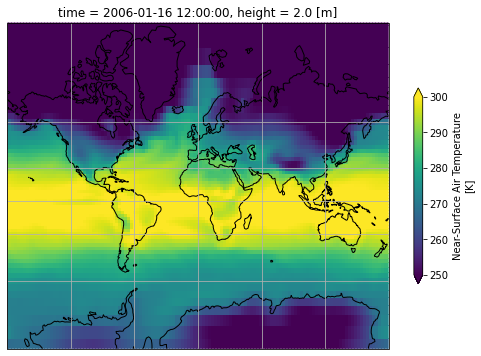

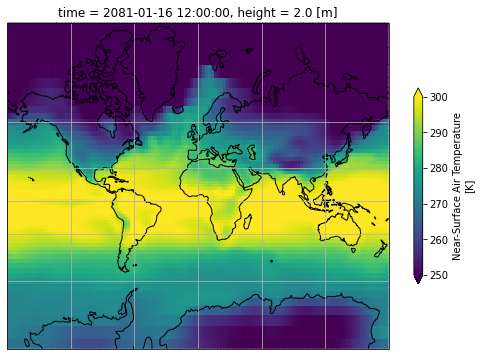

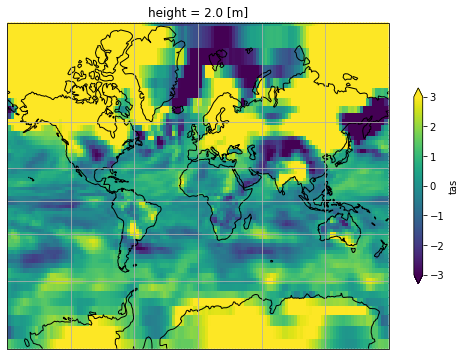

In [72]:
tas_test = ds_rcp26.tas.isel(time=0)# - 273.15
tas_test2 = ds_rcp26.tas.isel(time=900)# - 273.15
tas_diff = ds_rcp26.tas.isel(time=900) - ds_rcp26.tas.isel(time=0)
# This is the map projection we want to plot *onto*
   

fig = plt.figure(figsize=(9,6))
ax = plt.axes(projection=ccrs.Mercator())
ax.coastlines()
ax.gridlines()
# ax.set_extent([10, 60, 30, 50])
tas_test.plot(ax=ax, transform=ccrs.PlateCarree(),
             vmin=250, vmax=300, cbar_kwargs={'shrink': 0.6})


fig = plt.figure(figsize=(9,6))
ax = plt.axes(projection=ccrs.Mercator())
ax.coastlines()
ax.gridlines()
# ax.set_extent([10, 60, 30, 50])
tas_test2.plot(ax=ax, transform=ccrs.PlateCarree(),
             vmin=250, vmax=300, cbar_kwargs={'shrink': 0.6})

fig = plt.figure(figsize=(9,6))
ax = plt.axes(projection=ccrs.Mercator())
ax.coastlines()
ax.gridlines()
# ax.set_extent([10, 60, 30, 50])
tas_diff.plot(ax=ax, transform=ccrs.PlateCarree(),
             vmin=-3, vmax=3, cbar_kwargs={'shrink': 0.6})
			 
			 
# p = tas.plot(transform=ccrs.PlateCarree(),  # the data's projection
#              col='time', col_wrap=1,  # multiplot settings
#              aspect=ds_rcp26.dims['lon'] / ds_rcp26.dims['lat'],  # for a sensible figsize
#              subplot_kws={'projection': map_proj})  # the plot's projection

# We have to set the map's options on all axes
# for ax in p.axes.flat:
#     ax.coastlines()
#     ax.set_extent([10, 60, 30, 50])

In [75]:
print(tasmod.shape)

(1128, 64, 128)


In [76]:
print(ds_rcp26.tas)

<xarray.DataArray 'tas' (time: 1128, lat: 64, lon: 128)>
[9240576 values with dtype=float32]
Coordinates:
  * time     (time) object 2006-01-16 12:00:00 ... 2099-12-16 12:00:00
  * lat      (lat) float64 -87.86 -85.1 -82.31 -79.53 ... 79.53 82.31 85.1 87.86
  * lon      (lon) float64 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2
    height   float64 ...
Attributes:
    standard_name:     air_temperature
    long_name:         Near-Surface Air Temperature
    units:             K
    original_name:     TREFHT
    cell_methods:      time: mean (interval: 20 minutes)
    cell_measures:     area: areacella
    history:           2011-06-27T08:46:27Z altered by CMOR: Treated scalar d...
    associated_files:  baseURL: http://cmip-pcmdi.llnl.gov/CMIP5/dataLocation...


In [ ]:
# nt, nlat, nlon = tasmod.shape
# ngrd = nlon*nlat


# #Linear trend calculation
# tas_grd  = tasmod.reshape((nt, ngrd), order='F') 
# x        = np.linspace(1,nt,nt) #.reshape((nt,1))
# tas_rate = np.empty((ngrd,1))
# tas_rate[:,:] = np.nan

# for i in range(ngrd): 
#     y = tas_grd[:,i]   
#     if(not np.ma.is_masked(y)):         
#         z = np.polyfit(x, y, 1)
#         tas_rate[i,0] = z[0]*120.0

# tas_rate = tas_rate.reshape((nlat,nlon), order='F')

In [ ]:
# (2099-2006+1)#*12

In [77]:

tasmod_ym=tasmod.reshape(94,12,64,128)
# print(t2m_ym[1,1,0,0],t2m[13,0,0])


start_year=2006-2006
num_years=94
start_month=0
num_months=12
nx=tasmod_ym.shape[2]
ny=tasmod_ym.shape[3]
tasmod_trend, tasmod_trend_ym, tasmod_sig_a, tasmod_sig_a_ym, tasmod_r_a, tasmod_r_a_ym, tasmod_int_a, tasmod_int_a_ym = cal_trend(start_year, num_years, start_month, num_months, nx, ny, tasmod_ym)


0
1
2
3
4
5
6
7
8
9
10
11


In [78]:
print(ds.latitude)

<xarray.DataArray 'latitude' (latitude: 81)>
array([50.  , 49.75, 49.5 , 49.25, 49.  , 48.75, 48.5 , 48.25, 48.  , 47.75,
       47.5 , 47.25, 47.  , 46.75, 46.5 , 46.25, 46.  , 45.75, 45.5 , 45.25,
       45.  , 44.75, 44.5 , 44.25, 44.  , 43.75, 43.5 , 43.25, 43.  , 42.75,
       42.5 , 42.25, 42.  , 41.75, 41.5 , 41.25, 41.  , 40.75, 40.5 , 40.25,
       40.  , 39.75, 39.5 , 39.25, 39.  , 38.75, 38.5 , 38.25, 38.  , 37.75,
       37.5 , 37.25, 37.  , 36.75, 36.5 , 36.25, 36.  , 35.75, 35.5 , 35.25,
       35.  , 34.75, 34.5 , 34.25, 34.  , 33.75, 33.5 , 33.25, 33.  , 32.75,
       32.5 , 32.25, 32.  , 31.75, 31.5 , 31.25, 31.  , 30.75, 30.5 , 30.25,
       30.  ], dtype=float32)
Coordinates:
  * latitude  (latitude) float32 50.0 49.75 49.5 49.25 ... 30.75 30.5 30.25 30.0
Attributes:
    units:      degrees_north
    long_name:  latitude


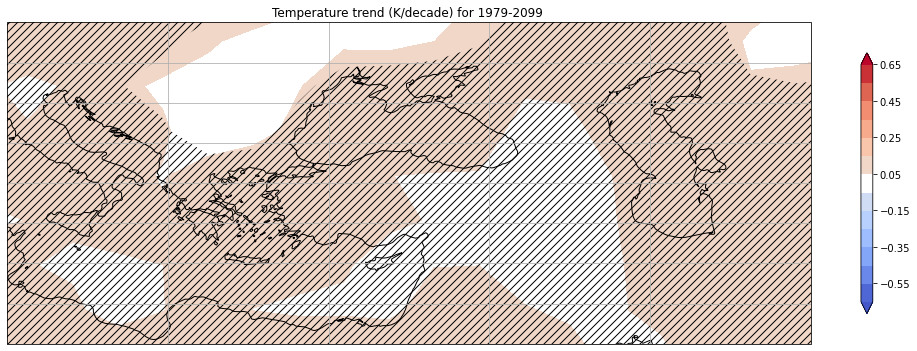

In [81]:
#Create color scheme and colorbar
biasContDist=0.1
rgrColorTable=np.array(['#4457c9','#4f67d4','#6988ea','#84a6f9','#9ebdff','#b7d0fd','#cfdcf3','#ffffff','#f1d7c8','#f9c5ab','#f7aa8c','#f28d72','#df6553','#c93137','#bc052b'])
iContNr=len(rgrColorTable)
iMinMax=12.*biasContDist/2.+biasContDist/2.
clevsTD=np.arange(-iMinMax,iMinMax+0.0001,biasContDist)

data=tasmod_trend
ds_trend = xr.DataArray(data, coords=[lat,lon], dims=["longitude","latitude"])
fig = plt.figure(figsize=(18,12))
# ax = plt.axes(projection=ccrs.Mercator())
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines()
# (ds_trend).plot.contourf(ax=ax, colors=rgrColorTable, levels=clevsTD, zorder=0, extend='both', cbar_kwargs={'shrink': 0.4})
cs=plt.contourf(lons,lats,tasmod_sig_a, hatches=['','///'],levels=[0,90,100], zorder=1, alpha=0)# ,transform=cartopy.crs.PlateCarree())
plt.contourf(lons,lats,10.*ds_trend,colors=rgrColorTable, extend='both',levels=clevsTD, zorder=0)
lat1, lon1, lat2, lon2 = 30, 10, 50, 60
ax.set_extent([lon1, lon2, lat1, lat2], crs=ccrs.PlateCarree())
plt.title('Temperature trend (K/decade) for 1979-2099 ')
# ax.set_extent(crs=ccrs.PlateCarree())
plt.colorbar(ax=ax,shrink=0.4)



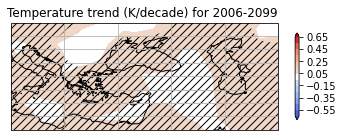

In [80]:
#Create color scheme and colorbar
biasContDist=0.1
rgrColorTable=np.array(['#4457c9','#4f67d4','#6988ea','#84a6f9','#9ebdff','#b7d0fd','#cfdcf3','#ffffff','#f1d7c8','#f9c5ab','#f7aa8c','#f28d72','#df6553','#c93137','#bc052b'])
iContNr=len(rgrColorTable)
iMinMax=12.*biasContDist/2.+biasContDist/2.
clevsTD=np.arange(-iMinMax,iMinMax+0.0001,biasContDist)

data=tasmod_trend
ds_trend = xr.DataArray(data, coords=[lat,lon], dims=["longitude","latitude"])
# fig = plt.figure(figsize=(18,12))
# ax = plt.axes(projection=ccrs.Mercator())
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines()
# (ds_trend).plot.contourf(ax=ax, colors=rgrColorTable, levels=clevsTD, zorder=0, extend='both', cbar_kwargs={'shrink': 0.4})
cs=plt.contourf(lons,lats,tasmod_sig_a, hatches=['','///'],levels=[0,90,100], zorder=1, alpha=0)# ,transform=cartopy.crs.PlateCarree())
plt.contourf(lons,lats,10.*ds_trend,colors=rgrColorTable, extend='both',levels=clevsTD, zorder=0)
lat1, lon1, lat2, lon2 = 30, 10, 50, 60
ax.set_extent([lon1, lon2, lat1, lat2], crs=ccrs.PlateCarree())
plt.title('Temperature trend (K/decade) for 2006-2099 ')
# ax.set_extent(crs=ccrs.PlateCarree())
plt.colorbar(ax=ax,shrink=0.4)



In [ ]:
# plt.figure(figsize=(18,15))
# ax = plt.axes(projection=ccrs.PlateCarree())
# ax.set_global()
# ax.coastlines()
# plt.pcolormesh(lons,lats,tas_rate,vmin=-0.1,vmax=0.1)
# # plt.contourf(lons,lats,tas_rate, extend='both')
# lat1, lon1, lat2, lon2 = 30, 10, 50, 60
# ax.set_extent([lon1, lon2, lat1, lat2], crs=ccrs.PlateCarree())
# plt.colorbar(ax=ax,shrink=0.4)
# plt.title('Temperature trends')

In [ ]:
print(ds_rcp26)

Text(0.5, 1.0, 'Compare yearly trends')

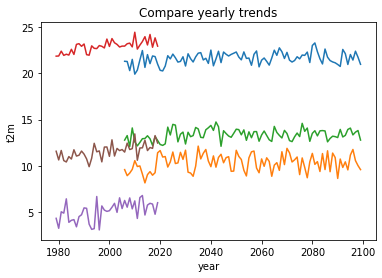

In [82]:

year_annual2 = (ds_rcp26['tas']-273.15).groupby('time.year').mean(dim='time')
year_annual2.sel(lon=lon1, lat=lat1, method = 'nearest').plot.line(x="year")
year_annual2.sel(lon=lon2, lat=lat2, method = 'nearest').plot.line(x="year")
year_annual2.sel(lon=lon3, lat=lat3, method = 'nearest').plot.line(x="year")
labels = ['Istanbul','Athens','Ankara']
# plt.legend(labels,loc='lower right')
# plt.title('Compare yearly trends')

year_annual = (ds['t2m']-273.15).groupby('time.year').mean(dim='time')
year_annual.sel(longitude=lon1, latitude=lat1, method = 'nearest').plot.line(x="year")
year_annual.sel(longitude=lon2, latitude=lat2, method = 'nearest').plot.line(x="year")
year_annual.sel(longitude=lon3, latitude=lat3, method = 'nearest').plot.line(x="year")
# labels = ['Istanbul','Athens','Ankara']
# plt.legend(labels,loc='upper right')
plt.title('Compare yearly trends')


Text(0.5, 1.0, 'Compare trends')

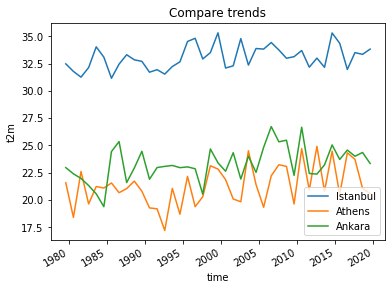

In [83]:
month=8 #9:September
(ds.t2m.sel(longitude=lon1, latitude=lat1,time=ds['time.month']==month, method = 'nearest')-273.15).plot.line(x="time")
(ds.t2m.sel(longitude=lon2, latitude=lat2,time=ds['time.month']==month, method = 'nearest')-273.15).plot.line(x="time")
(ds.t2m.sel(longitude=lon3, latitude=lat3,time=ds['time.month']==month, method = 'nearest')-273.15).plot.line(x="time")
labels = ['Istanbul','Athens','Ankara']
plt.legend(labels,loc='lower right')
plt.title('Compare trends')

## RCP 8.5

In [84]:
# import cdsapi
# #https://cds.climate.copernicus.eu/cdsapp#!/dataset/projections-cmip5-daily-single-levels?tab=form

# c = cdsapi.Client()

# c.retrieve(
#     'projections-cmip5-monthly-single-levels',
#     {
# #         'area' : [50, 10, 30, 60], # North, West, South, East. Default: global
#         'ensemble_member': 'r1i1p1',
#         'format': 'zip',
#         'experiment': 'rcp_8_5',
#         'variable': [
#             '2m_temperature','surface_pressure',
#         ],
#         'period': '200601-209912',
#         'model': 'bcc_csm1_1',
#     },
#     '../data/download_85.zip')



In [85]:
# #Unzip .zip file 
# with zipfile.ZipFile('../data/download_85.zip','r') as zip_ref:
#     zip_ref.extractall('../data/')
    
# #Add to path
# import os
# from pathlib import Path

# p = Path(os.getcwd())
# p.joinpath('./')

In [86]:
#Read data 
mod = netcdf(r'./tas_Amon_bcc-csm1-1_rcp85_r1i1p1_200601-209912.nc')
mod.set_auto_mask(False)
 
#Read variables
lon = mod['lon'][:]  
lat = mod['lat'][:] 
t = mod['time'][:]    
tasmod_rcp85 = mod['tas'][0:1128,:] #Choosing 2m temperature as variable to analyse


[lons_rcp85, lats_rcp85] = meshgrid(lon,lat)

In [87]:
#load data
import xarray as xr
ds_rcp85 = xr.open_dataset('./tas_Amon_bcc-csm1-1_rcp85_r1i1p1_200601-209912.nc')
print(ds_rcp85)

<xarray.Dataset>
Dimensions:    (time: 1128, bnds: 2, lat: 64, lon: 128)
Coordinates:
  * time       (time) object 2006-01-16 12:00:00 ... 2099-12-16 12:00:00
  * lat        (lat) float64 -87.86 -85.1 -82.31 -79.53 ... 82.31 85.1 87.86
  * lon        (lon) float64 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2
    height     float64 ...
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) object ...
    lat_bnds   (lat, bnds) float64 ...
    lon_bnds   (lon, bnds) float64 ...
    tas        (time, lat, lon) float32 ...
Attributes: (12/30)
    institution:            Beijing Climate Center(BCC),China Meteorological ...
    institute_id:           BCC
    experiment_id:          rcp85
    source:                 bcc-csm1-1:atmosphere:  BCC_AGCM2.1 (T42L26); lan...
    model_id:               bcc-csm1-1
    forcing:                Nat Ant GHG SD Oz Sl SS Ds BC OC
    ...                     ...
    modeling_realm:         atmos
    realization:            1


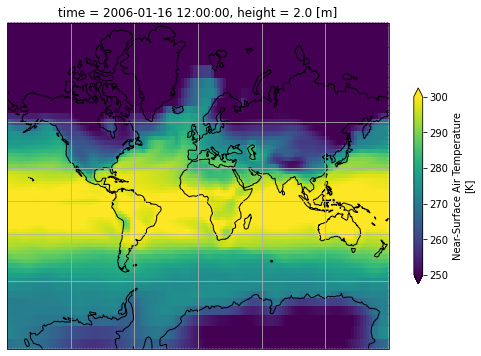

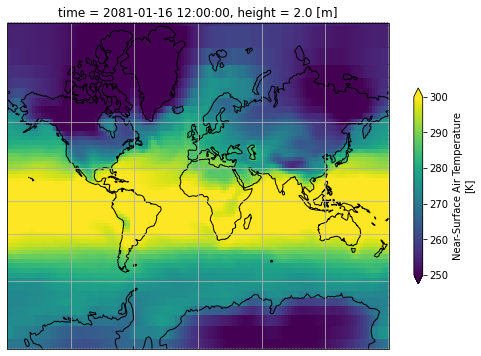

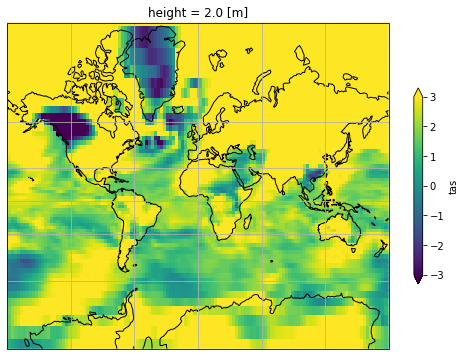

In [88]:
tas_test = ds_rcp85.tas.isel(time=0)# - 273.15
tas_test2 = ds_rcp85.tas.isel(time=900)# - 273.15
tas_diff = ds_rcp85.tas.isel(time=900) - ds_rcp85.tas.isel(time=0)
# This is the map projection we want to plot *onto*
   

fig = plt.figure(figsize=(9,6))
ax = plt.axes(projection=ccrs.Mercator())
ax.coastlines()
ax.gridlines()
# ax.set_extent([10, 60, 30, 50])
tas_test.plot(ax=ax, transform=ccrs.PlateCarree(),
             vmin=250, vmax=300, cbar_kwargs={'shrink': 0.6})


fig = plt.figure(figsize=(9,6))
ax = plt.axes(projection=ccrs.Mercator())
ax.coastlines()
ax.gridlines()
# ax.set_extent([10, 60, 30, 50])
tas_test2.plot(ax=ax, transform=ccrs.PlateCarree(),
             vmin=250, vmax=300, cbar_kwargs={'shrink': 0.6})

fig = plt.figure(figsize=(9,6))
ax = plt.axes(projection=ccrs.Mercator())
ax.coastlines()
ax.gridlines()
# ax.set_extent([10, 60, 30, 50])
tas_diff.plot(ax=ax, transform=ccrs.PlateCarree(),
             vmin=-3, vmax=3, cbar_kwargs={'shrink': 0.6})

# p = tas.plot(transform=ccrs.PlateCarree(),  # the data's projection
#              col='time', col_wrap=1,  # multiplot settings
#              aspect=ds_rcp26.dims['lon'] / ds_rcp26.dims['lat'],  # for a sensible figsize
#              subplot_kws={'projection': map_proj})  # the plot's projection

# We have to set the map's options on all axes
# for ax in p.axes.flat:
#     ax.coastlines()
#     ax.set_extent([10, 60, 30, 50])

In [ ]:
# nt, nlat, nlon = tasmod_rcp85.shape
# ngrd = nlon*nlat


# #Linear trend calculation
# tas_grd  = tasmod_rcp85.reshape((nt, ngrd), order='F') 
# x        = np.linspace(1,nt,nt) #.reshape((nt,1))
# tas_rate = np.empty((ngrd,1))
# tas_rate[:,:] = np.nan

# for i in range(ngrd): 
#     y = tas_grd[:,i]   
#     if(not np.ma.is_masked(y)):         
#         z = np.polyfit(x, y, 1)
#         tas_rate[i,0] = z[0]*120.0

# tas_rate = tas_rate.reshape((nlat,nlon), order='F')

In [89]:

tasmod_rcp85_ym=tasmod_rcp85.reshape(94,12,64,128)
# print(t2m_ym[1,1,0,0],t2m[13,0,0])


start_year=2006-2006
num_years=94
start_month=0
num_months=12
nx=tasmod_rcp85_ym.shape[2]
ny=tasmod_rcp85_ym.shape[3]
tasmod_rcp85_trend, tasmod_rcp85_trend_ym, tasmod_rcp85_sig_a, tasmod_rcp85_sig_a_ym, tasmod_rcp85_r_a, tasmod_rcp85_r_a_ym, tasmod_rcp85_int_a, tasmod_rcp85_int_a_ym = cal_trend(start_year, num_years, start_month, num_months, nx, ny, tasmod_rcp85_ym)


0
1
2
3
4
5
6
7
8
9
10
11


In [90]:
print(ds.latitude)

<xarray.DataArray 'latitude' (latitude: 81)>
array([50.  , 49.75, 49.5 , 49.25, 49.  , 48.75, 48.5 , 48.25, 48.  , 47.75,
       47.5 , 47.25, 47.  , 46.75, 46.5 , 46.25, 46.  , 45.75, 45.5 , 45.25,
       45.  , 44.75, 44.5 , 44.25, 44.  , 43.75, 43.5 , 43.25, 43.  , 42.75,
       42.5 , 42.25, 42.  , 41.75, 41.5 , 41.25, 41.  , 40.75, 40.5 , 40.25,
       40.  , 39.75, 39.5 , 39.25, 39.  , 38.75, 38.5 , 38.25, 38.  , 37.75,
       37.5 , 37.25, 37.  , 36.75, 36.5 , 36.25, 36.  , 35.75, 35.5 , 35.25,
       35.  , 34.75, 34.5 , 34.25, 34.  , 33.75, 33.5 , 33.25, 33.  , 32.75,
       32.5 , 32.25, 32.  , 31.75, 31.5 , 31.25, 31.  , 30.75, 30.5 , 30.25,
       30.  ], dtype=float32)
Coordinates:
  * latitude  (latitude) float32 50.0 49.75 49.5 49.25 ... 30.75 30.5 30.25 30.0
Attributes:
    units:      degrees_north
    long_name:  latitude


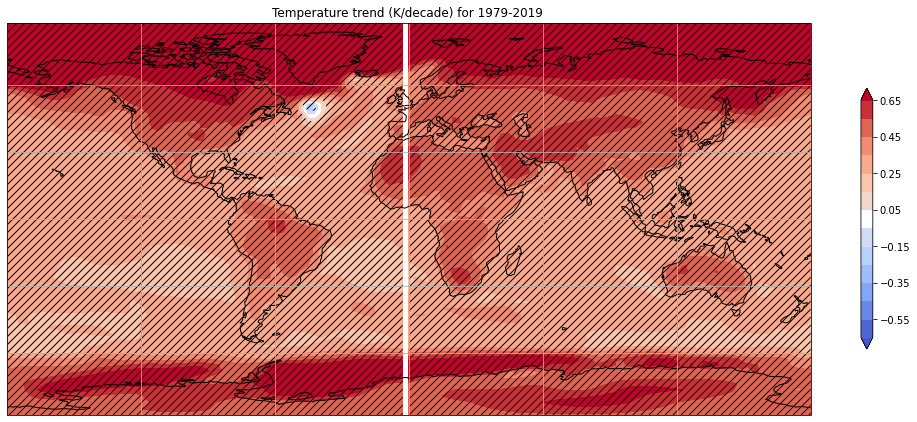

In [94]:
#Create color scheme and colorbar
biasContDist=0.1
rgrColorTable=np.array(['#4457c9','#4f67d4','#6988ea','#84a6f9','#9ebdff','#b7d0fd','#cfdcf3','#ffffff','#f1d7c8','#f9c5ab','#f7aa8c','#f28d72','#df6553','#c93137','#bc052b'])
iContNr=len(rgrColorTable)
iMinMax=12.*biasContDist/2.+biasContDist/2.
clevsTD=np.arange(-iMinMax,iMinMax+0.0001,biasContDist)

data=tasmod_rcp85_trend
ds_trend = xr.DataArray(data, coords=[lat,lon], dims=["longitude","latitude"])
fig = plt.figure(figsize=(18,12))
# ax = plt.axes(projection=ccrs.Mercator())
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines()
# (ds_trend).plot.contourf(ax=ax, colors=rgrColorTable, levels=clevsTD, zorder=0, extend='both', cbar_kwargs={'shrink': 0.4})
cs=plt.contourf(lons_rcp85,lats_rcp85,tasmod_rcp85_sig_a, hatches=['','///'],levels=[0,90,100], zorder=1, alpha=0)# ,transform=cartopy.crs.PlateCarree())
plt.contourf(lons_rcp85,lats_rcp85,10.*ds_trend,colors=rgrColorTable, extend='both',levels=clevsTD, zorder=0)
# lat1, lon1, lat2, lon2 = 30, 10, 50, 60
# ax.set_extent([lon1, lon2, lat1, lat2], crs=ccrs.PlateCarree())
plt.title('Temperature trend (K/decade) for 1979-2019 ')
# ax.set_extent(crs=ccrs.PlateCarree())
plt.colorbar(ax=ax,shrink=0.4)



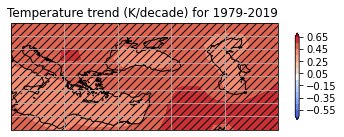

In [95]:
#Create color scheme and colorbar
biasContDist=0.1
rgrColorTable=np.array(['#4457c9','#4f67d4','#6988ea','#84a6f9','#9ebdff','#b7d0fd','#cfdcf3','#ffffff','#f1d7c8','#f9c5ab','#f7aa8c','#f28d72','#df6553','#c93137','#bc052b'])
iContNr=len(rgrColorTable)
iMinMax=12.*biasContDist/2.+biasContDist/2.
clevsTD=np.arange(-iMinMax,iMinMax+0.0001,biasContDist)

data=tasmod_rcp85_trend
ds_trend = xr.DataArray(data, coords=[lat,lon], dims=["longitude","latitude"])
# fig = plt.figure(figsize=(18,12))
# ax = plt.axes(projection=ccrs.Mercator())
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines()
# (ds_trend).plot.contourf(ax=ax, colors=rgrColorTable, levels=clevsTD, zorder=0, extend='both', cbar_kwargs={'shrink': 0.4})
cs=plt.contourf(lons_rcp85,lats_rcp85,tasmod_rcp85_sig_a, hatches=['','///'],levels=[0,90,100], zorder=1, alpha=0)# ,transform=cartopy.crs.PlateCarree())
plt.contourf(lons_rcp85,lats_rcp85,10.*ds_trend,colors=rgrColorTable, extend='both',levels=clevsTD, zorder=0)
lat1, lon1, lat2, lon2 = 30, 10, 50, 60
ax.set_extent([lon1, lon2, lat1, lat2], crs=ccrs.PlateCarree())
plt.title('Temperature trend (K/decade) for 1979-2019 ')
# ax.set_extent(crs=ccrs.PlateCarree())
plt.colorbar(ax=ax,shrink=0.4)



In [ ]:
# plt.figure(figsize=(18,15))
# ax = plt.axes(projection=ccrs.PlateCarree())
# ax.set_global()
# ax.coastlines()
# plt.pcolormesh(lons,lats,tas_rate,vmin=-0.1,vmax=0.1)
# # plt.contourf(lons,lats,tas_rate, extend='both')
# lat1, lon1, lat2, lon2 = 30, 10, 50, 60
# ax.set_extent([lon1, lon2, lat1, lat2], crs=ccrs.PlateCarree())
# plt.colorbar(ax=ax,shrink=0.4)
# plt.title('Temperature trends')

In [ ]:
# print(ds_rcp26)

Text(0.5, 1.0, 'Compare yearly trends')

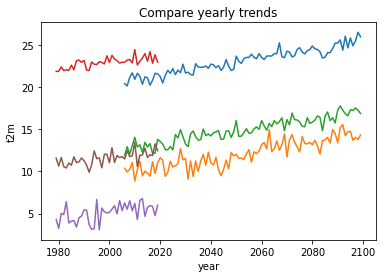

In [96]:

year_annual3 = (ds_rcp85['tas']-273.15).groupby('time.year').mean(dim='time')
year_annual3.sel(lon=lon1, lat=lat1, method = 'nearest').plot.line(x="year")
year_annual3.sel(lon=lon2, lat=lat2, method = 'nearest').plot.line(x="year")
year_annual3.sel(lon=lon3, lat=lat3, method = 'nearest').plot.line(x="year")
labels = ['Istanbul','Athens','Ankara']
# plt.legend(labels,loc='lower right')
# plt.title('Compare yearly trends')

year_annual = (ds['t2m']-273.15).groupby('time.year').mean(dim='time')
year_annual.sel(longitude=lon1, latitude=lat1, method = 'nearest').plot.line(x="year")
year_annual.sel(longitude=lon2, latitude=lat2, method = 'nearest').plot.line(x="year")
year_annual.sel(longitude=lon3, latitude=lat3, method = 'nearest').plot.line(x="year")
# labels = ['Istanbul','Athens','Ankara']
# plt.legend(labels,loc='upper right')
plt.title('Compare yearly trends')


In [ ]:
# # (ds.t2m.sel(longitude=lon1, latitude=lat1,time=ds['time.month']==month, method = 'nearest')-273.15).plot.line(x="time")
# month=8

# # year_annual3 = (ds_rcp85['tas']-273.15).groupby('time.year').mean(dim='time')
# (ds_rcp85['tas']-273.15).sel(lon=lon1, lat=lat1, time=ds_rcp85['time.month']==month, method = 'nearest').plot.line(x="time")
# (ds_rcp85['tas']-273.15).sel(lon=lon2, lat=lat2, time=ds_rcp85['time.month']==month, method = 'nearest').plot.line(x="time")
# (ds_rcp85['tas']-273.15).sel(lon=lon3, lat=lat3, time=ds_rcp85['time.month']==month, method = 'nearest').plot.line(x="time")
# # labels = ['Istanbul','Athens','Ankara']
# # plt.legend(labels,loc='lower right')
# # plt.title('Compare yearly trends')

# # year_annual = (ds['t2m']-273.15).groupby('time.year').mean(dim='time')
# (ds['t2m']-273.15).sel(longitude=lon1, latitude=lat1, time=ds['time.month']==month, method = 'nearest').plot.line(x="time")
# (ds['t2m']-273.15).sel(longitude=lon2, latitude=lat2, time=ds['time.month']==month, method = 'nearest').plot.line(x="time")
# (ds['t2m']-273.15).sel(longitude=lon3, latitude=lat3, time=ds['time.month']==month, method = 'nearest').plot.line(x="time")
# # labels = ['Istanbul','Athens','Ankara']
# # plt.legend(labels,loc='upper right')
# plt.title('Compare yearly trends')


In [97]:
print(ds_rcp85['time.month'])

<xarray.DataArray 'month' (time: 1128)>
array([ 1,  2,  3, ..., 10, 11, 12])
Coordinates:
  * time     (time) object 2006-01-16 12:00:00 ... 2099-12-16 12:00:00
    height   float64 2.0


In [99]:
# plt.figure(figsize=(18,15))
# ax = plt.axes(projection=ccrs.PlateCarree())
# ax.set_global()
# ax.coastlines()
# plt.pcolormesh(lons,lats,tas_rate,vmin=0,vmax=1.)
# # llevels = np.arange(0,1,0.1) # check etopo.ravel().max()
# # plt.contourf(lons,lats,tas_rate,levels=llevels, extend='both')
# lat1, lon1, lat2, lon2 = 30, 10, 50, 60
# ax.set_extent([lon1, lon2, lat1, lat2], crs=ccrs.PlateCarree())
# plt.colorbar(ax=ax,shrink=0.4)
# plt.title('Temperature trends K/decade')

# Analysing temperature data from weather stations


https://github.com/daniel-codes/temperature-trends/blob/master/temperature_trends.ipynb

https://gis.ncdc.noaa.gov/maps/ncei/summaries/daily


https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/figures/station-counts-1891-1920-temp.png


All stations codes are here:
https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/ghcnd-stations.txt

Some python code to fetch and analyse the weather station data is here:
https://github.com/yoavfreund/UCSD_BigData/blob/master/notebooks/weather/Weather%20Analysis.ipynb

Manual download based on station code you are interested in
https://www.ncdc.noaa.gov/cdo-web/confirmation

Here are the climate regions:
https://www.weather.gov/jetstream/climate_max

In [ ]:
# ankara = pd.read_csv('../data/Ank_obs_ERA5.csv', 
#                   sep=",",
#                   parse_dates=['Date'],
#                   index_col=['Date'],)

# # ankara

In [ ]:
# ankara = pd.read_csv('../data/Ank_obs_ERA5.csv')#, parse_dates=[0], index_col=0)
# ankara

In [ ]:
# ankara = pd.read_csv('../data/Ank_obs_ERA5.csv', header=0, parse_dates=[0], index_col=0)
# ankara


In [ ]:
# ankara.dtypes

In [ ]:
# ankara['Date'] = pd.to_datetime(ankara['Date'], format = '%Y-%m-%d')
# ankara.dtypes

In [ ]:
# ankara.ank_obs.plot()



Reading csv files to pandaframes is a messy business 

See here for some explanation https://machinelearningmastery.com/load-explore-time-series-data-python/

In [ ]:
# Istanbul = pd.read_csv('../data/Istanbul_2304366.csv',
#                   parse_dates=['DATE'],
#                   index_col=['DATE'])
# Istanbul

Istanbul = pd.read_csv('../data/Istanbul_2304366.csv', parse_dates=[5], index_col=5)
Istanbul

STATION          NAME  LATITUDE  LONGITUDE  ELEVATION  PRCP  \
DATE                                                                          
1929-01-01  TU000017062  ISTANBUL, TU   40.9667    29.0831       33.0   NaN   
1929-01-02  TU000017062  ISTANBUL, TU   40.9667    29.0831       33.0   NaN   
1929-01-03  TU000017062  ISTANBUL, TU   40.9667    29.0831       33.0   NaN   
1929-01-04  TU000017062  ISTANBUL, TU   40.9667    29.0831       33.0   NaN   
1929-01-05  TU000017062  ISTANBUL, TU   40.9667    29.0831       33.0  0.31   
...                 ...           ...       ...        ...        ...   ...   
2007-05-05  TU000017062  ISTANBUL, TU   40.9667    29.0831       33.0  0.00   
2007-05-06  TU000017062  ISTANBUL, TU   40.9667    29.0831       33.0  0.00   
2007-05-07  TU000017062  ISTANBUL, TU   40.9667    29.0831       33.0  0.00   
2007-05-08  TU000017062  ISTANBUL, TU   40.9667    29.0831       33.0  0.00   
2007-05-09  TU000017062  ISTANBUL, TU   40.9667    29.0831       33.0   NaN   

           PRCP_ATTRIBUTES  SNWD SNWD_ATTRIBUTES  TAVG TAVG_ATTRIBUTES  TMAX  \
DATE                                                                           
1929-01-01             NaN   NaN             NaN   NaN             NaN  60.0   
1929-01-02             NaN   NaN             NaN   NaN             NaN  62.0   
1929-01-03             NaN   NaN             NaN   NaN             NaN  63.0   
1929-01-04             NaN   NaN             NaN   NaN             NaN  58.0   
1929-01-05             ,,I   NaN             NaN   NaN             NaN  57.0   
...                    ...   ...             ...   ...             ...   ...   
2007-05-05            B,,S   NaN             NaN  61.0            H,,S  73.0   
2007-05-06            B,,S   NaN             NaN  69.0            H,,S  86.0   
2007-05-07            B,,S   NaN             NaN  68.0            H,,S  83.0   
2007-05-08            B,,S   NaN             NaN  67.0            H,,S  78.0   
2007-05-09             NaN   NaN             NaN  65.0            H,,S   NaN   

           TMAX_ATTRIBUTES  TMIN TMIN_ATTRIBUTES  
DATE                                              
1929-01-01             ,,G  49.0             ,,G  
1929-01-02             ,,G  50.0             ,,G  
1929-01-03             ,,G  49.0             ,,G  
1929-01-04             ,,G  48.0             ,,G  
1929-01-05             ,,G  45.0             ,,G  
...                    ...   ...             ...  
2007-05-05             ,,S  48.0             ,,S  
2007-05-06             ,,S  57.0             ,,S  
2007-05-07             ,,S  56.0             ,,S  
2007-05-08             ,,S  61.0             ,,S  
2007-05-09             NaN  57.0             ,,S  

[27442 rows x 15 columns]

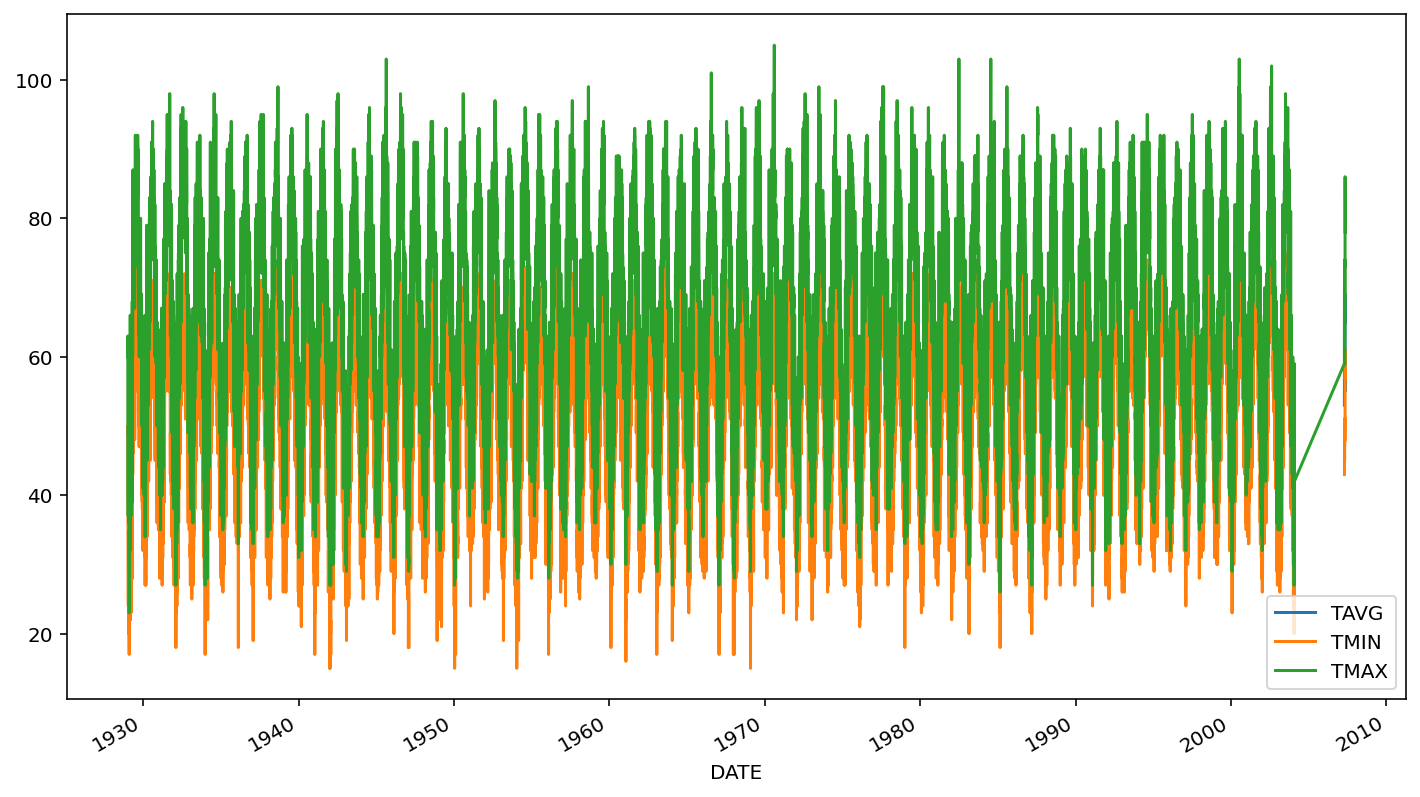

In [ ]:
Istanbul.TAVG.plot()
Istanbul.TMIN.plot()
Istanbul.TMAX.plot()
labels = ['TAVG','TMIN','TMAX']
plt.legend(labels,loc='lower right')

In [ ]:
# series = read_csv('daily-total-female-births-in-cal.csv', header=0, parse_dates=[0], index_col=0, squeeze=True)
Athens = pd.read_csv('../data/Athens_2304376.csv', parse_dates=[5], index_col=5)
# print(Athens.DATE)
Athens

STATION            NAME  LATITUDE  LONGITUDE  ELEVATION  PRCP  \
DATE                                                                            
1958-01-01  GRE00105246     TANAGRA, GR   38.3167    23.5331      140.0   NaN   
1958-01-02  GRE00105246     TANAGRA, GR   38.3167    23.5331      140.0   NaN   
1958-01-03  GRE00105246     TANAGRA, GR   38.3167    23.5331      140.0   NaN   
1958-01-04  GRE00105246     TANAGRA, GR   38.3167    23.5331      140.0   NaN   
1958-01-05  GRE00105246     TANAGRA, GR   38.3167    23.5331      140.0   NaN   
...                 ...             ...       ...        ...        ...   ...   
2020-09-27  GR000016716  HELLINIKON, GR   37.9000    23.7500       10.0   0.0   
2020-09-28  GR000016716  HELLINIKON, GR   37.9000    23.7500       10.0   0.0   
2020-09-29  GR000016716  HELLINIKON, GR   37.9000    23.7500       10.0   0.0   
2020-09-30  GR000016716  HELLINIKON, GR   37.9000    23.7500       10.0   0.0   
2020-10-01  GR000016716  HELLINIKON, GR   37.9000    23.7500       10.0   0.0   

           PRCP_ATTRIBUTES  SNWD SNWD_ATTRIBUTES  TAVG TAVG_ATTRIBUTES  TMAX  \
DATE                                                                           
1958-01-01             NaN   NaN             NaN   NaN             NaN  58.0   
1958-01-02             NaN   NaN             NaN   NaN             NaN  61.0   
1958-01-03             NaN   NaN             NaN   NaN             NaN  60.0   
1958-01-04             NaN   NaN             NaN   NaN             NaN  51.0   
1958-01-05             NaN   NaN             NaN   NaN             NaN  46.0   
...                    ...   ...             ...   ...             ...   ...   
2020-09-27             ,,S   NaN             NaN  74.0            H,,S  82.0   
2020-09-28             ,,S   NaN             NaN  76.0            H,,S  80.0   
2020-09-29             ,,S   NaN             NaN  76.0            H,,S  83.0   
2020-09-30             ,,S   NaN             NaN  72.0            H,,S  79.0   
2020-10-01             ,,S   NaN             NaN  71.0            H,,S  81.0   

           TMAX_ATTRIBUTES  TMIN TMIN_ATTRIBUTES  
DATE                                              
1958-01-01             ,,E  40.0             ,,E  
1958-01-02             ,,E  40.0             ,,E  
1958-01-03             ,,E  37.0             ,,E  
1958-01-04             ,,E  40.0             ,,E  
1958-01-05             ,,E  40.0             ,,E  
...                    ...   ...             ...  
2020-09-27             ,,S  66.0             ,,S  
2020-09-28             ,,S  70.0             ,,S  
2020-09-29             ,,S  71.0             ,,S  
2020-09-30             ,,S  65.0             ,,S  
2020-10-01             ,,S  63.0             ,,S  

[40298 rows x 15 columns]

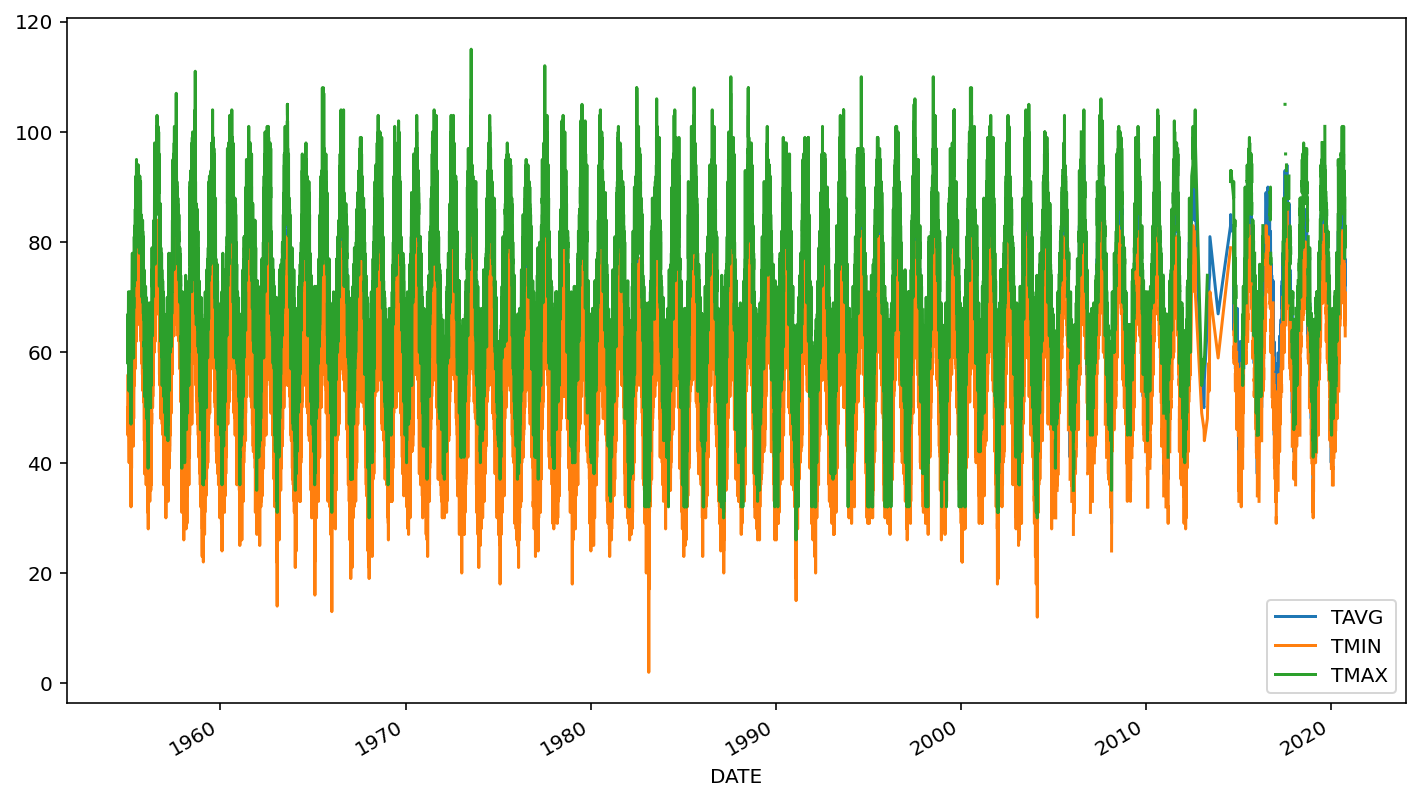

In [ ]:
Athens.TAVG.plot()
Athens.TMIN.plot()
Athens.TMAX.plot()
labels = ['TAVG','TMIN','TMAX']
plt.legend(labels,loc='lower right')

A simple approach for plotting

https://pypi.org/project/pystuff/

In [ ]:
Athens = pd.read_csv('../data/Athens_2304376.csv')
Athens
myvar1=Athens['TMIN'].values
myvar2=Athens['TAVG'].values
myvar3=Athens['TMAX'].values
time=pd.to_datetime(Athens['DATE'].values)

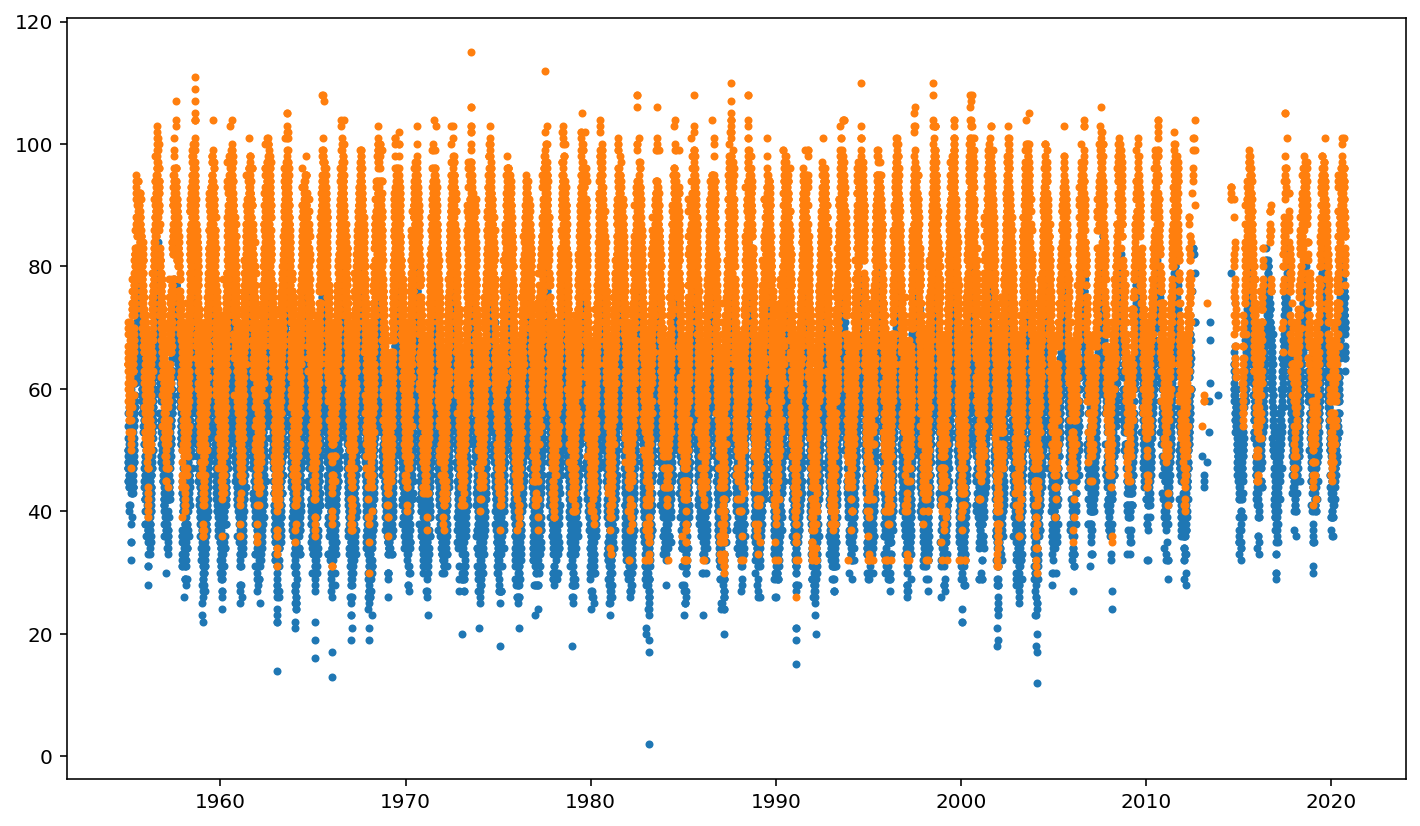

In [ ]:
plt.plot(time,myvar1,'.')
plt.plot(time,myvar3,'.')

In [ ]:
time.month.shape

(40298,)

NameError: name 'season_str' is not defined

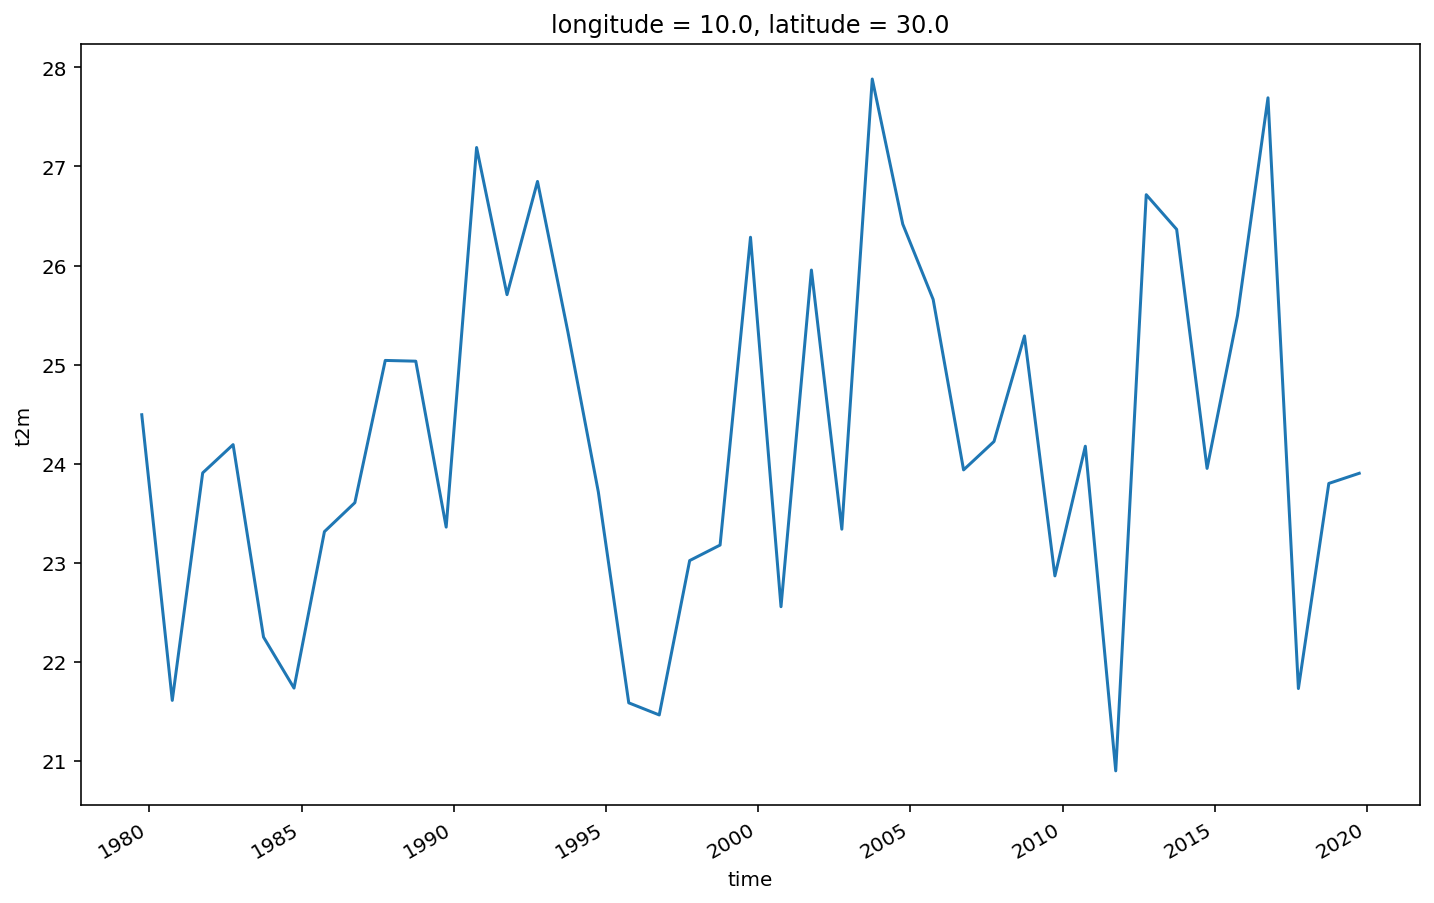

In [ ]:
(ds.t2m.sel(longitude=lon1, latitude=lat1,time=ds['time.month']==month, method = 'nearest')-273.15).plot.line(x="time")
season_annual = ds['t2m'].where(ds['t2m']['time.season'] == season_str).groupby('time.year').mean(dim='time')


In [ ]:
month=8
myvar1.where(time.month==month).groupby(

SyntaxError: unexpected EOF while parsing (<ipython-input-54-21ee10fd4ac4>, line 2)

<AxesSubplot:xlabel='DATE'>

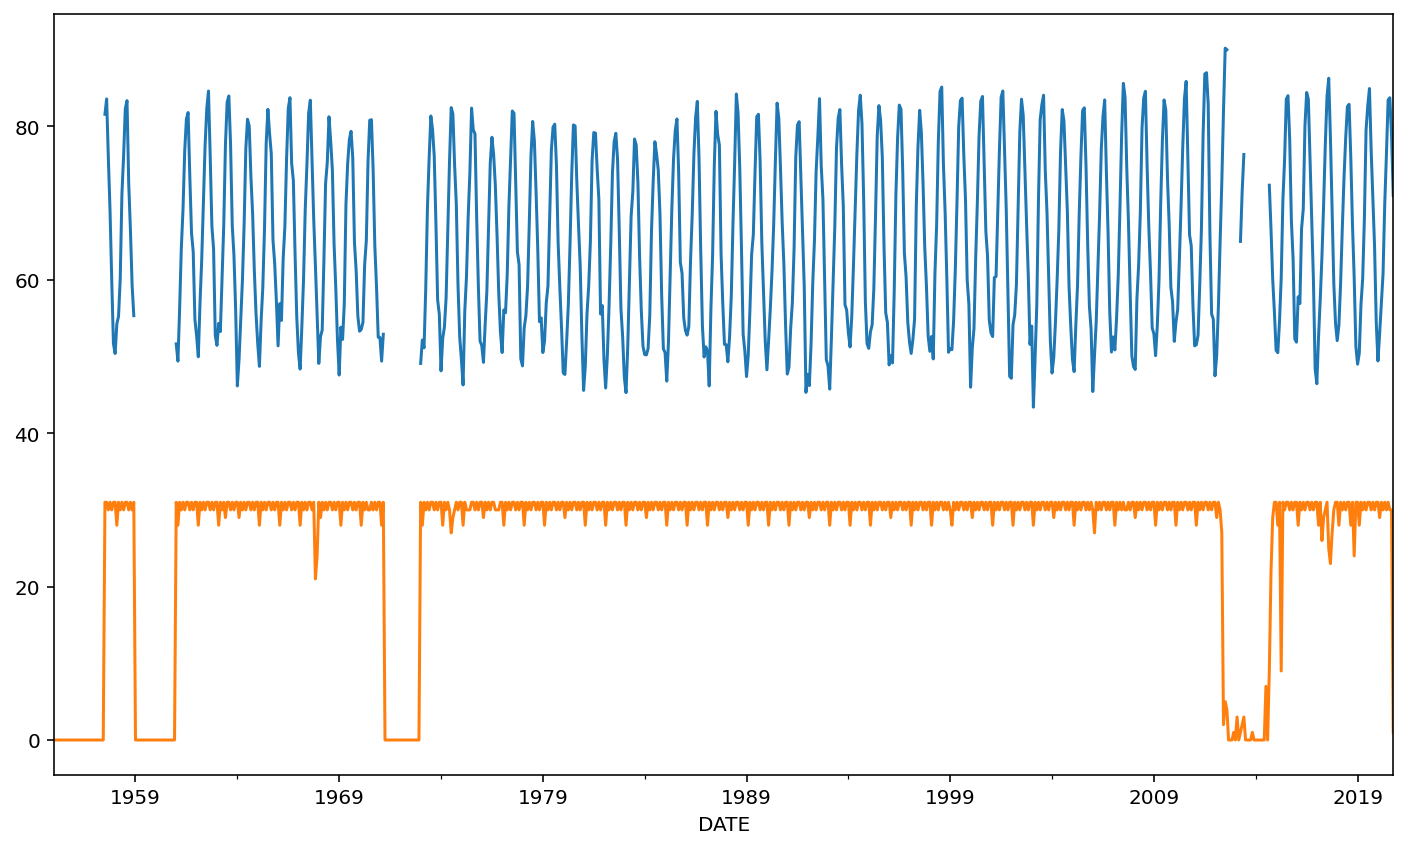

In [ ]:
#https://stackoverflow.com/questions/23859840/python-aggregate-by-month-and-calculate-average
Athens = pd.read_csv('../data/Athens_2304376.csv', parse_dates=[5], index_col=5)
# Athens.resample('M').mean()
# Athens.resample('M').mean().TMIN.plot()
Athens.resample('M').mean().TAVG.plot()
Athens.resample('M').count().TAVG.plot()

# Athens.resample('M').mean().TMAX.plot()

<AxesSubplot:xlabel='DATE'>

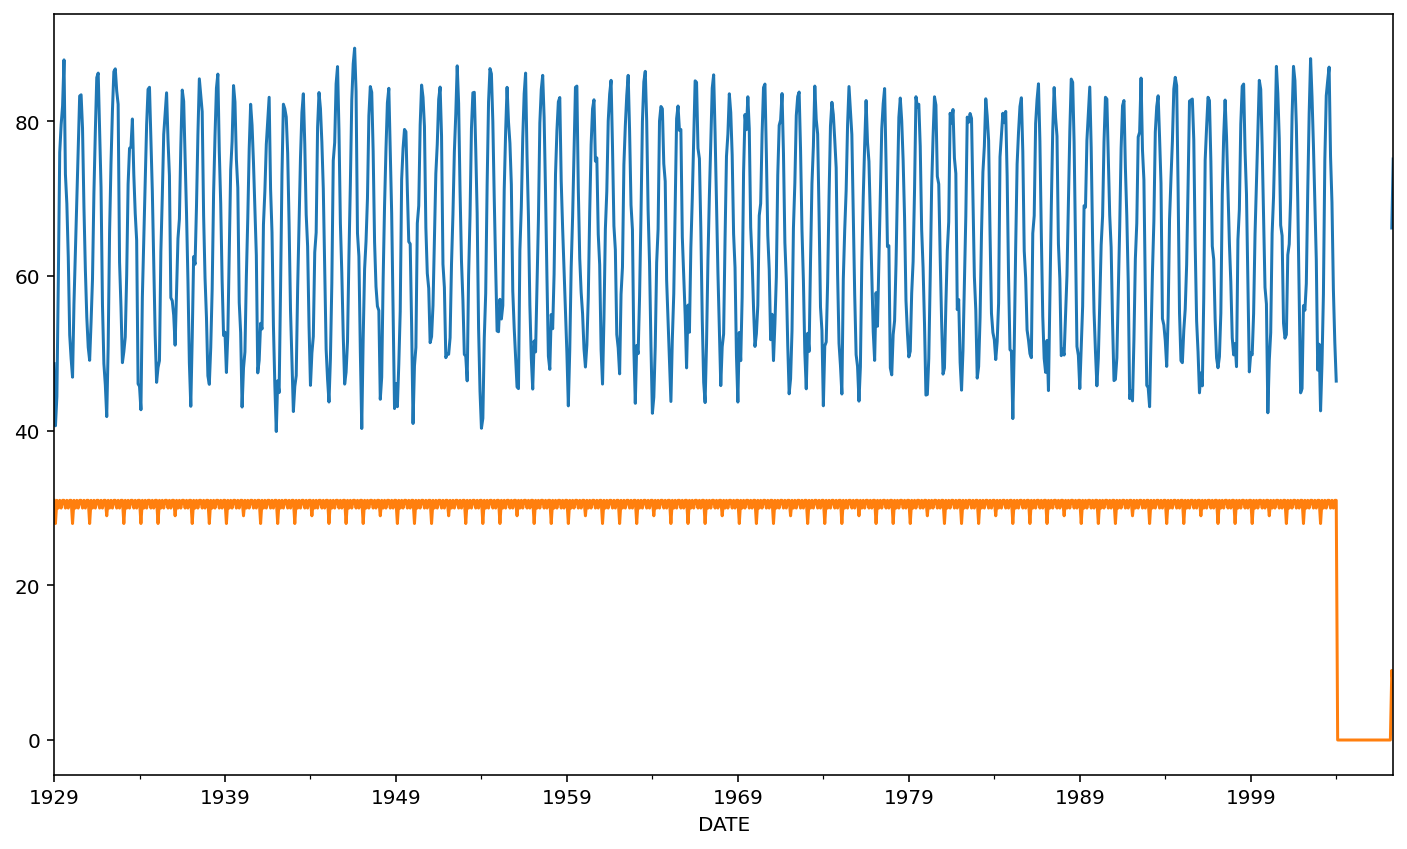

In [ ]:
#https://stackoverflow.com/questions/23859840/python-aggregate-by-month-and-calculate-average
Istanbul = pd.read_csv('../data/Istanbul_2304366.csv', parse_dates=[5], index_col=5)
# Athens.resample('M').mean()
# Athens.resample('M').mean().TMIN.plot()
Istanbul.resample('M').mean().TMAX.plot()
Istanbul.resample('M').count().TMAX.plot()

# Istanbul.resample('M').mean().TMAX.plot()

<AxesSubplot:xlabel='DATE'>

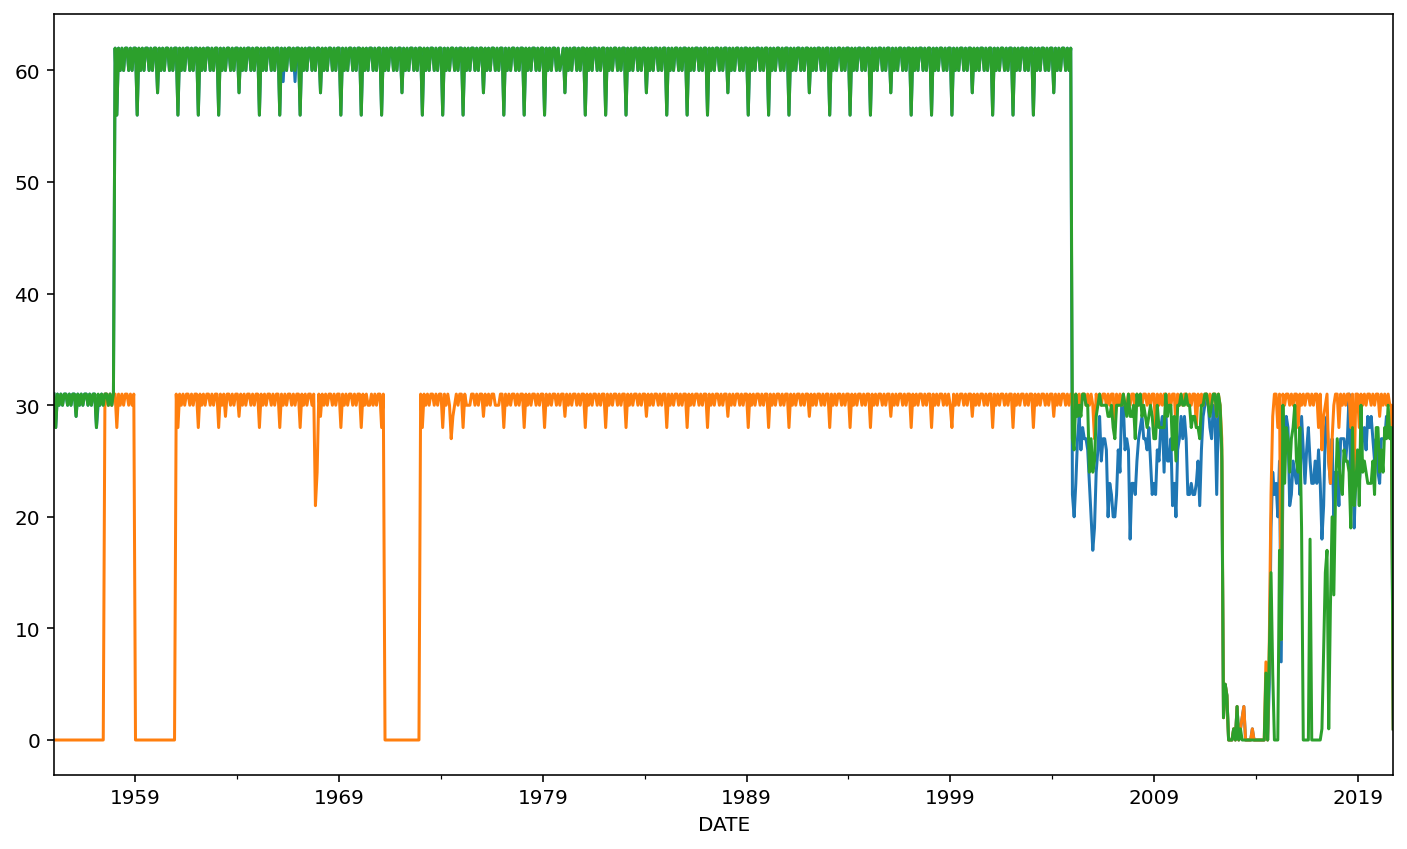

In [ ]:
Athens.resample('M').count().TMIN.plot()
Athens.resample('M').count().TAVG.plot()
Athens.resample('M').count().TMAX.plot()

In [ ]:
type(Athens)

pandas.core.frame.DataFrame

Group data by month and year and average 

https://stackoverflow.com/questions/29762546/monthly-averages-using-daily-data-using-python-pandas

In [ ]:
# # b = pd.read_csv('b.dat')
# Athens.index = pd.to_datetime(Athens.DATE,format='%m/%d/%y')
# # Athens.groupby(by=[Athens.index.month, Athens.index.year])

In [ ]:
# Athens.TMIN.groupby(pd.Grouper(freq='M')).plot()


In [ ]:
# # Group data first by year, then by month
# g = Athens.groupby(["year", "month"])

# # For each group, calculate the average of only the snow_depth column
# # monthly_averages = g.aggregate({"TMIN":np.mean})

Manipulate pandas dataframe timeseries https://aetperf.github.io/2018/05/24/Pandas-Time-Series-example-with-some-historical-land-temperatures.html

2021-02-26 13:05:55,046 INFO NumExpr defaulting to 4 threads.


Text(0, 0.5, 'Temperature min (°C)')

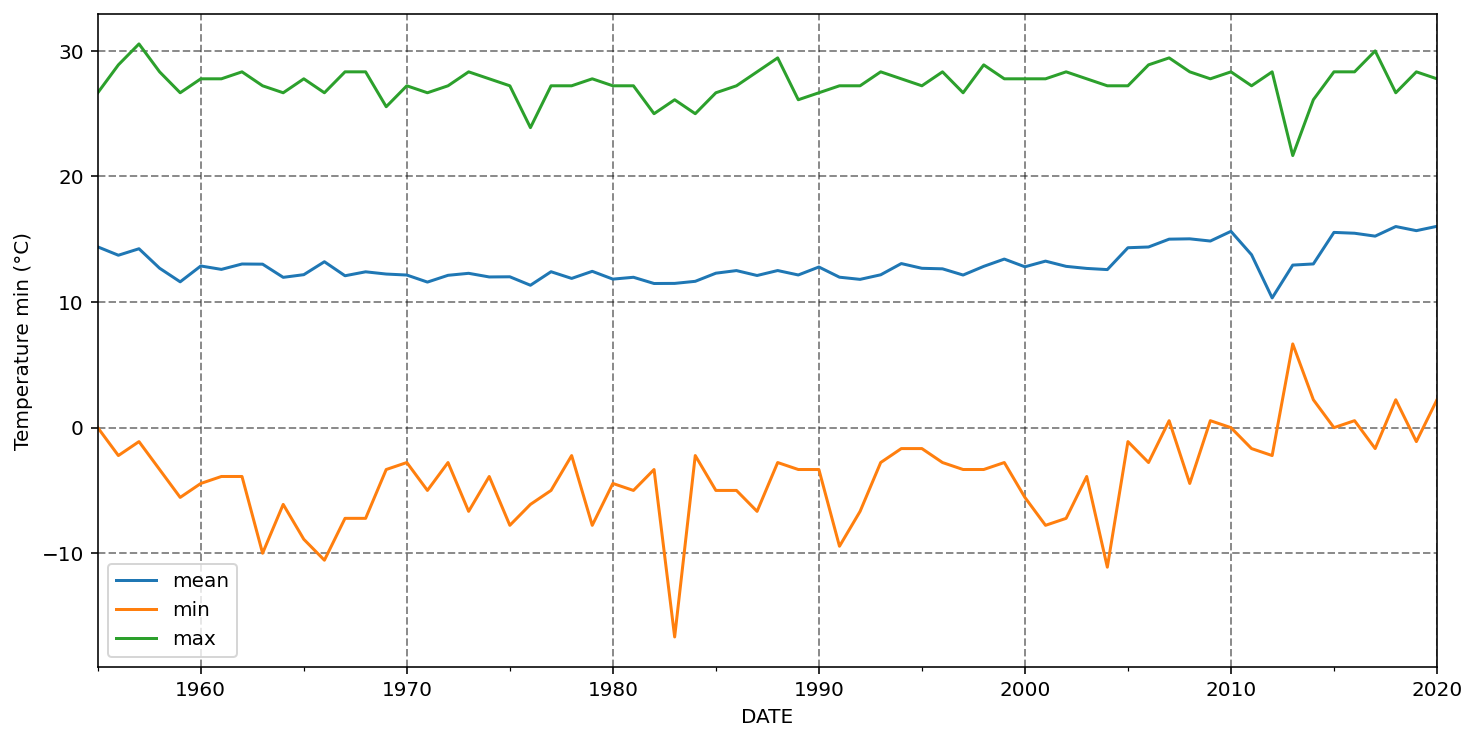

In [ ]:
Athens_annual = Athens.resample("AS").agg(['mean', 'min', 'max'])
((Athens_annual.TMIN - 32.) * 5. / 9.).plot(figsize=(12, 6))
ax = plt.gca()
ax.grid(color=(0.1, 0.1, 0.1), linestyle='--', linewidth=1, alpha=0.5)
plt.autoscale(enable=True, axis='x', tight=True)
plt.ylabel("Temperature min (°C)")
# sns.despine()

In [ ]:
# Athens_annual = Athens.resample("AS").agg(['mean', 'min', 'max'])
# ((Athens_annual.TMAX-32.)*5./9.).plot(figsize=(12, 6))
# ax = plt.gca()
# ax.grid(color= (0.1, 0.1, 0.1), linestyle='--', linewidth=1, alpha=0.5)
# plt.autoscale(enable=True, axis='x', tight=True)
# plt.ylabel("Temperature max (°C)")
# # sns.despine()

Text(0, 0.5, 'Temperature (°C)')

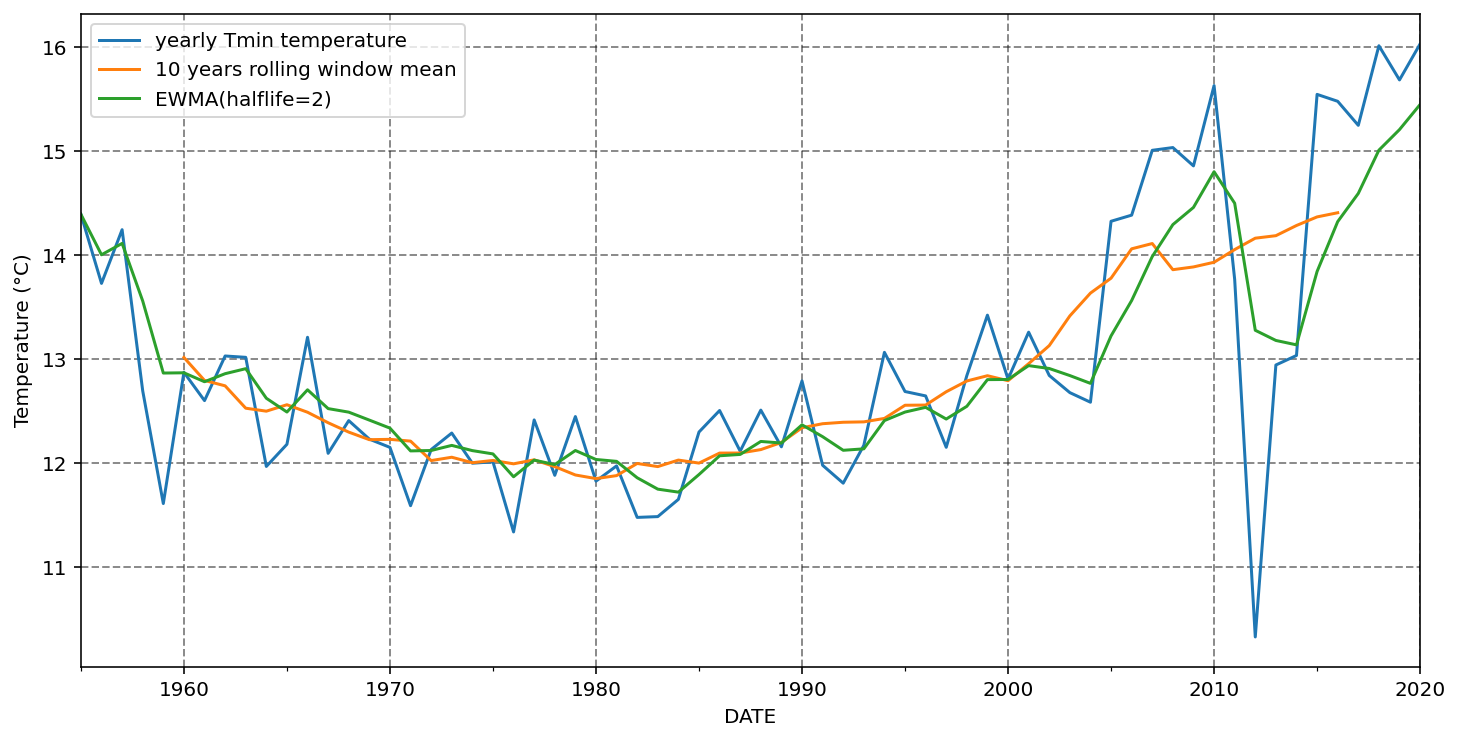

In [ ]:
((Athens_annual[('TMIN', 'mean')]-32.)*5./9.).plot(label='yearly Tmin temperature', figsize=(12, 6))
((Athens_annual[('TMIN', 'mean')]-32.)*5./9.).rolling(10, center=True).mean().plot(label='10 years rolling window mean')
((Athens_annual[('TMIN', 'mean')]-32.)*5./9.).ewm(halflife=2).mean().plot(label='EWMA(halflife=2)')  # Exponentially-weighted moving average
ax = plt.gca()
ax.grid(color= (0.1, 0.1, 0.1), linestyle='--', linewidth=1, alpha=0.5)
plt.autoscale(enable=True, axis='x', tight=True)
plt.legend()
plt.ylabel("Temperature (°C)")
# sns.despine()

In [ ]:
# Istanbul = pd.read_csv('../data/Istanbul_2304366.csv',
#                   parse_dates=['DATE'],
#                   index_col=['DATE'])
# Istanbul

Istanbul = pd.read_csv('../data/Istanbul_2304366.csv', parse_dates=[5], index_col=5)
Istanbul

STATION          NAME  LATITUDE  LONGITUDE  ELEVATION  PRCP  \
DATE                                                                          
1929-01-01  TU000017062  ISTANBUL, TU   40.9667    29.0831       33.0   NaN   
1929-01-02  TU000017062  ISTANBUL, TU   40.9667    29.0831       33.0   NaN   
1929-01-03  TU000017062  ISTANBUL, TU   40.9667    29.0831       33.0   NaN   
1929-01-04  TU000017062  ISTANBUL, TU   40.9667    29.0831       33.0   NaN   
1929-01-05  TU000017062  ISTANBUL, TU   40.9667    29.0831       33.0  0.31   
...                 ...           ...       ...        ...        ...   ...   
2007-05-05  TU000017062  ISTANBUL, TU   40.9667    29.0831       33.0  0.00   
2007-05-06  TU000017062  ISTANBUL, TU   40.9667    29.0831       33.0  0.00   
2007-05-07  TU000017062  ISTANBUL, TU   40.9667    29.0831       33.0  0.00   
2007-05-08  TU000017062  ISTANBUL, TU   40.9667    29.0831       33.0  0.00   
2007-05-09  TU000017062  ISTANBUL, TU   40.9667    29.0831       33.0   NaN   

           PRCP_ATTRIBUTES  SNWD SNWD_ATTRIBUTES  TAVG TAVG_ATTRIBUTES  TMAX  \
DATE                                                                           
1929-01-01             NaN   NaN             NaN   NaN             NaN  60.0   
1929-01-02             NaN   NaN             NaN   NaN             NaN  62.0   
1929-01-03             NaN   NaN             NaN   NaN             NaN  63.0   
1929-01-04             NaN   NaN             NaN   NaN             NaN  58.0   
1929-01-05             ,,I   NaN             NaN   NaN             NaN  57.0   
...                    ...   ...             ...   ...             ...   ...   
2007-05-05            B,,S   NaN             NaN  61.0            H,,S  73.0   
2007-05-06            B,,S   NaN             NaN  69.0            H,,S  86.0   
2007-05-07            B,,S   NaN             NaN  68.0            H,,S  83.0   
2007-05-08            B,,S   NaN             NaN  67.0            H,,S  78.0   
2007-05-09             NaN   NaN             NaN  65.0            H,,S   NaN   

           TMAX_ATTRIBUTES  TMIN TMIN_ATTRIBUTES  
DATE                                              
1929-01-01             ,,G  49.0             ,,G  
1929-01-02             ,,G  50.0             ,,G  
1929-01-03             ,,G  49.0             ,,G  
1929-01-04             ,,G  48.0             ,,G  
1929-01-05             ,,G  45.0             ,,G  
...                    ...   ...             ...  
2007-05-05             ,,S  48.0             ,,S  
2007-05-06             ,,S  57.0             ,,S  
2007-05-07             ,,S  56.0             ,,S  
2007-05-08             ,,S  61.0             ,,S  
2007-05-09             NaN  57.0             ,,S  

[27442 rows x 15 columns]

<AxesSubplot:xlabel='DATE'>

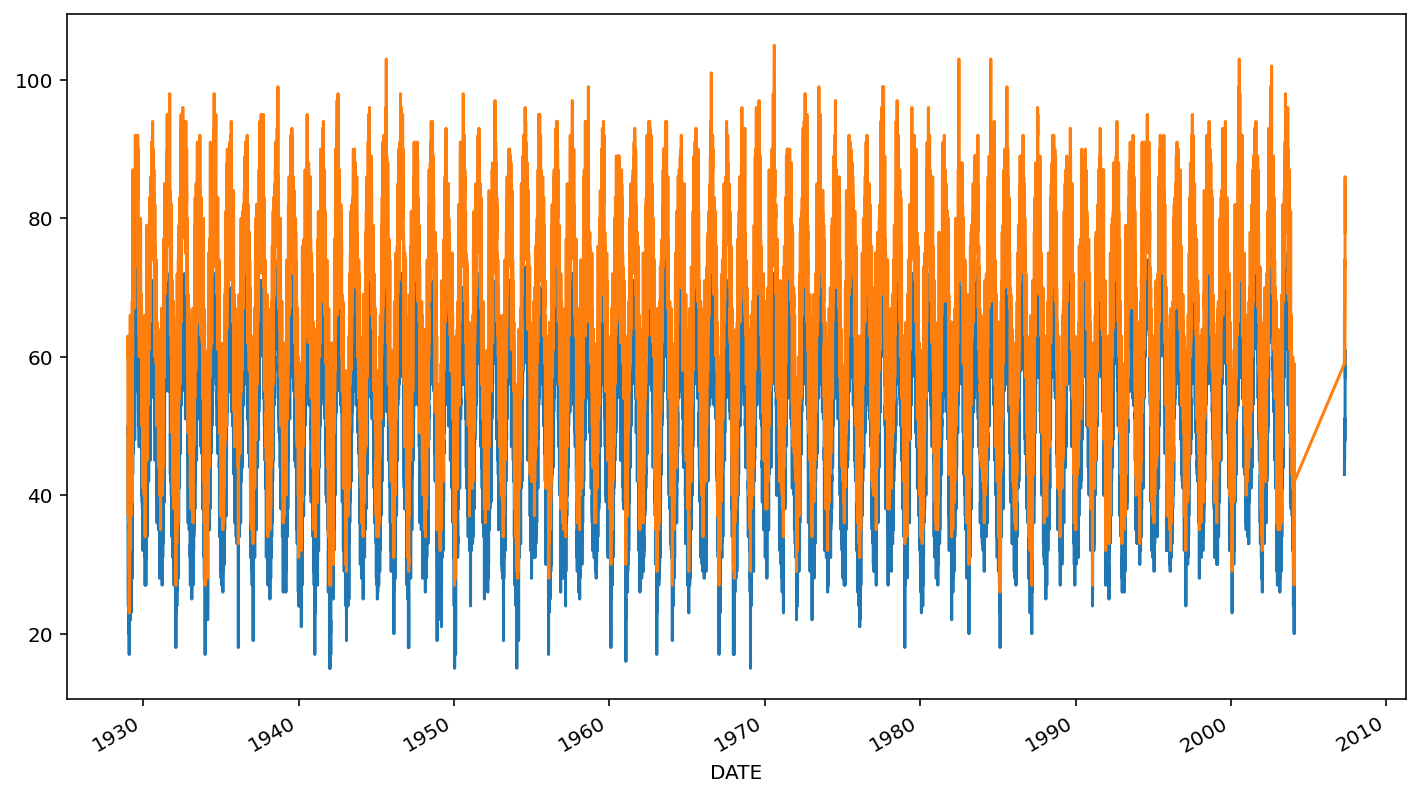

In [ ]:
Istanbul.TMIN.plot()
Istanbul.TMAX.plot()

In [ ]:
# Athens = pd.read_csv('../data/Athens_2304376.csv')
# Athens
# myvar1=Athens['TMIN'].values
# myvar2=Athens['TAVG'].values
# myvar3=Athens['TMAX'].values
# time=pd.to_datetime(Athens['DATE'].values)

Istanbul = pd.read_csv('../data/Istanbul_2304366.csv')
myvar1=((Istanbul_annual.TMIN-32.)*5./9.).values
myvar2=((Istanbul_annual.TMAX-32.)*5./9.).values
time1=pd.to_datetime(Istanbul['DATE'].values)
myvar3=(ds['t2m']-273.15).groupby('time.year').mean(dim='time').sel(longitude=lon1, latitude=lat1, method = 'nearest')
# print(myvar1.shape)
print(myvar3)
print(time1)

NameError: name 'Istanbul_annual' is not defined

NameError: name 'Istanbul_annual' is not defined

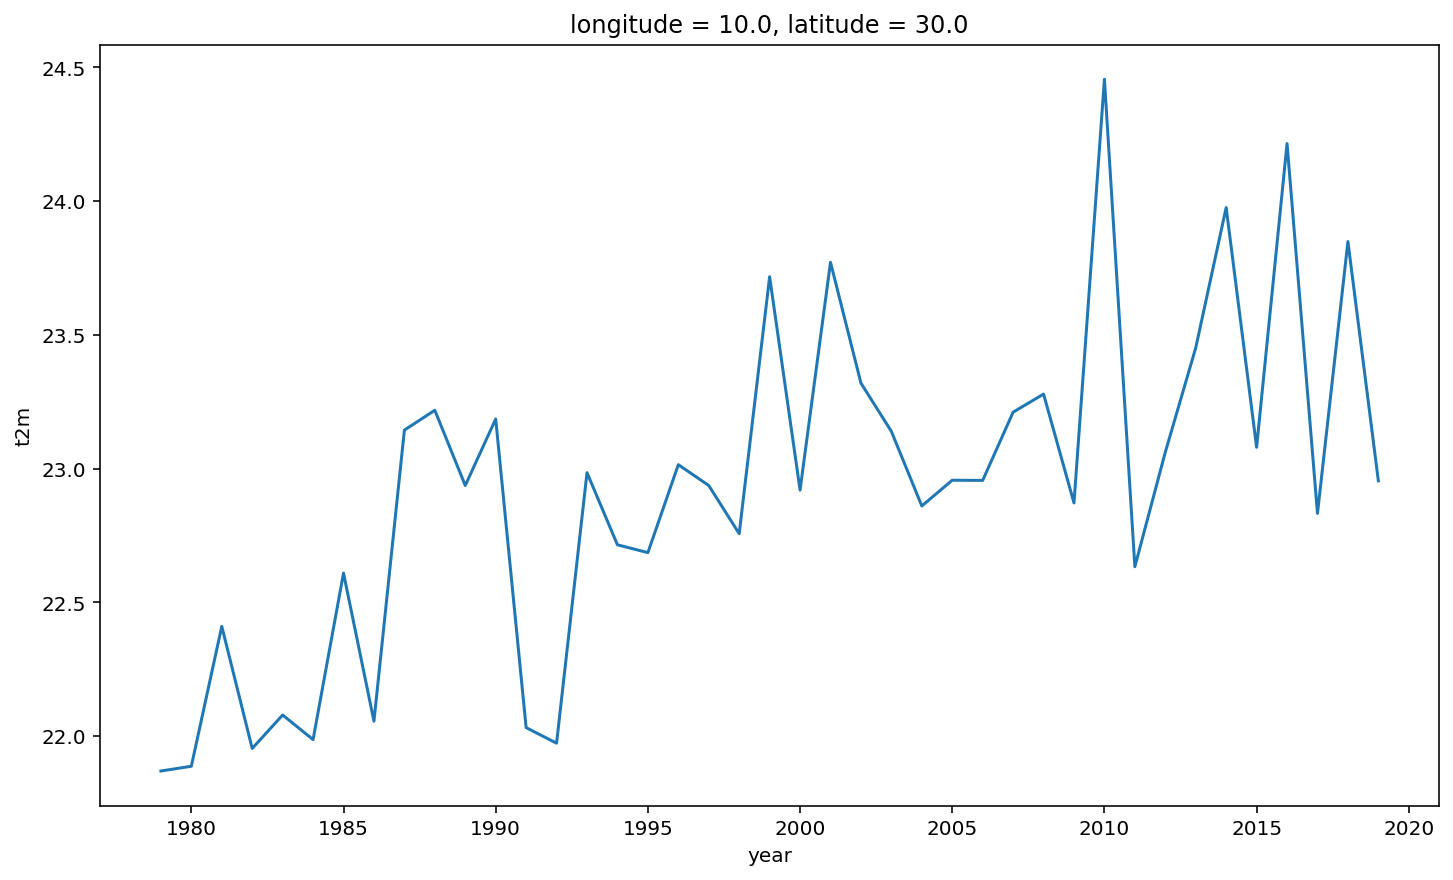

In [ ]:
year_annual = (ds['t2m']-273.15).groupby('time.year').mean(dim='time')
year_annual.sel(longitude=lon1, latitude=lat1, method = 'nearest').plot.line(x="year")
((Istanbul_annual.TMIN-32.)*5./9.).plot()
((Istanbul_annual.TMAX-32.)*5./9.).plot()
# print((ds['t2m']-273.15).groupby('time.year').mean(dim='time'))

In [ ]:


Istanbul_annual = Istanbul.resample("AS").agg(mean)
# Istanbul_annual = Istanbul.resample("AS").agg(['mean', 'min', 'max'])
((Istanbul_annual.TMIN-32.)*5./9.).plot()
((Istanbul_annual.TMAX-32.)*5./9.).plot()
ax = plt.gca()
ax.grid(color= (0.1, 0.1, 0.1), linestyle='--', linewidth=1, alpha=0.5)
plt.autoscale(enable=True, axis='x', tight=True)
plt.ylabel("Temperature min (°C)")
# sns.despine()
print(((Istanbul_annual.TMIN-32.)*5./9.))

TypeError: Only valid with DatetimeIndex, TimedeltaIndex or PeriodIndex, but got an instance of 'RangeIndex'

In [ ]:
# Istanbul['time'] = pd.to_datetime(Istanbul['DATE'], format = '%Y-%m-%d')
# Istanbul_xr=Istanbul.to_xarray()

# print(Istanbul_xr)
# print(Istanbul)

In [ ]:
# month=8
# # Istanbul_xr.TMIN.sel(time=Istanbul['time.month']==month).plot()
# Istanbul_xr.TMIN.plot(x='time')

NameError: name 'lon3' is not defined

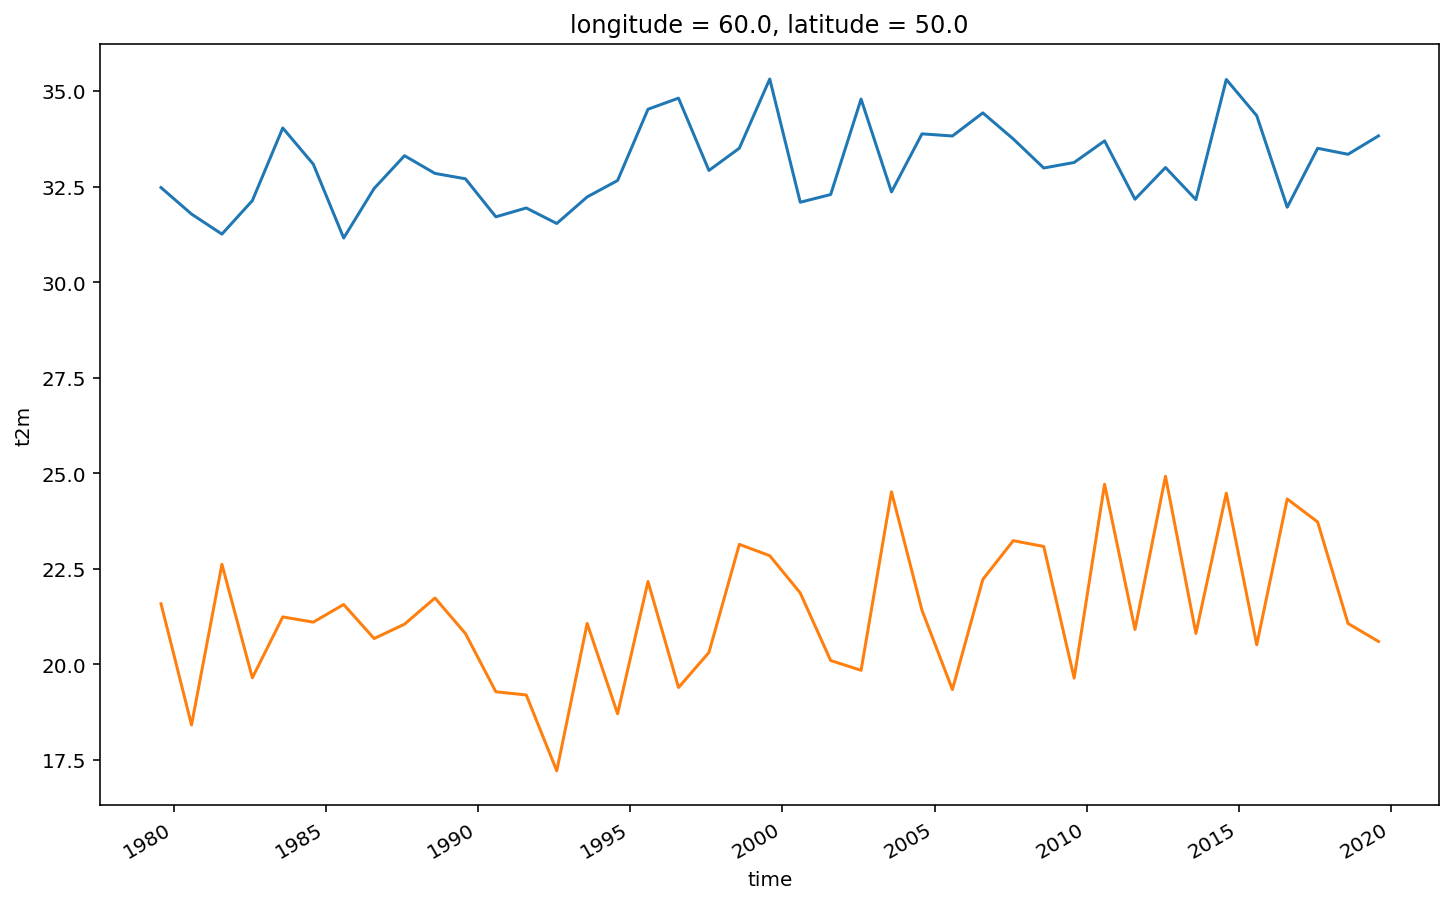

In [ ]:
month=8 #9:September
(ds.t2m.sel(longitude=lon1, latitude=lat1,time=ds['time.month']==month, method = 'nearest')-273.15).plot.line(x="time")
(ds.t2m.sel(longitude=lon2, latitude=lat2,time=ds['time.month']==month, method = 'nearest')-273.15).plot.line(x="time")
(ds.t2m.sel(longitude=lon3, latitude=lat3,time=ds['time.month']==month, method = 'nearest')-273.15).plot.line(x="time")
labels = ['Istanbul','Athens','Ankara']
plt.legend(labels,loc='lower right')
plt.title('Compare trends')

In [ ]:
date_time_str = '1958-01-01'
date_time_obj = datetime.datetime.strptime(date_time_str, '%Y-%m-%d')

In [ ]:
date_time_obj

datetime.datetime(1958, 1, 1, 0, 0)

In [ ]:
                llevels = np.arange(-2000,0,250) # check etopo.ravel().max()

llevels

# Extra material 

In [ ]:
# create an xarray
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

data = np.random.random((6, 3, 11))
da = xr.DataArray(data, dims=['longitude', 'latitude', 'time'], name='foo')

region_data = np.random.choice(range(6), size=(6, 3))
region = xr.DataArray(region_data, dims=['longitude', 'latitude'], name='region')

ds_test = xr.merge([da, region])

In [ ]:
print(ds_test)

<xarray.Dataset>
Dimensions:  (latitude: 3, longitude: 6, time: 11)
Dimensions without coordinates: latitude, longitude, time
Data variables:
    foo      (longitude, latitude, time) float64 0.05745 0.188 ... 0.2136 0.8605
    region   (longitude, latitude) int64 1 5 5 5 1 2 1 3 0 3 0 1 4 2 5 0 4 1


<font size="4">And some *sea* __ice__ to finish</font>


In [ ]:
#https://www.nccs.nasa.gov/nccs-users/instructional/adapt-instructional/python/xarray-time-series-analysis

from statsmodels.tsa.seasonal import seasonal_decompose
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
URL = 'https://esgf.nccs.nasa.gov/thredds/dodsC/CMIP6.CMIP.NASA-GISS.GISS-E2-1-G.historical.r1i1p1f1.SImon.sithick.gn.sithick.20180827.aggregation.1'
nc = xr.open_dataset(URL)
lat = nc['lat'][:]
lon = nc['lon'][:]
data = nc['sithick'][:, :,:]
data_mean = data.mean(['lat', 'lon']) # wonderful tool to calculate spatial mean by using dim variable names
time = nc['time'].to_dataframe().index
pdtime = time.to_datetimeindex() #convert this index to a pandas.DatetimeIndex
plt.plot(pdtime, data_mean, color='red', linewidth=2, label='SeaIce Thickness')
plt.title('Time Series of Global Mean SeaIce Thickness from CMIP.NASA-GISS.GISS-E2-1-G.historical.r2i1p1f1.SImon.sithick')
plt.xlabel('time (year)')
plt.ylabel('SeaIce Thickness (M)')
plt.show()
data1 = pd.Series(data_mean)
data1.index = pdtime
result = seasonal_decompose(data1, model='multiplicative', freq=12)
result.plot()
plt.xlabel('time (year)')
plt.show()